# AIN313 - Assignment 4 (Fall 2025) - Human Action Classification from Pose Time-Series

> **Goal:** Build **4** human-action classifiers from **OpenPose BODY-25** pose time-series and compare them with **ablation studies** and **clear plots/tables**.

**Due:** Dec 26, 2025 23:59:59

**Dataset (summary):**
- 6 actions: boxing, handclapping, handwaving, jogging, running, walking
- ~160x120 resolution, 25 fps, 25 actors
- Download link: use the Google Drive link provided in the PDF

**Deliverables (single zip, do not include dataset):**
- `project.ipynb` (report + code, self-contained)
- `project.py` (exported from notebook)
- Name: `project_studentIDs.zip`

**Team members (fill in):**
- **Person A:** _Şeyma DOĞAN, 2230765034_
- **Person B:** _Dinara ALIYEVA, 2220765059_

**How to use this notebook**
- Keep results reproducible: fix seeds, log configs, save metrics tables/figures.
- Each method needs an ablation study (multiple configs), not a single run.

---

## Global TODO (shared)
- [X] Confirm OpenPose extraction method (CLI or Python bindings) → **CLI-based extraction used**
- [X] Confirm dataset path(s) and label mapping (6 classes) → **KTH dataset, 6 action classes**
- [X] Agree on pose representation: `(x,y)` or `(x,y,conf)` and joint subset policy → **Using (x,y) only, all 25 BODY-25 joints**
- [X] Agree on evaluation protocol: stratified split (and/or CV), metrics, ablation grid size → **GroupShuffleSplit by person ID (LOSO), macro-F1 + accuracy**
- [X] Decide the extra method (must be course-related and time-series suitable) → **Temporal 1D CNN**

## 0. Assumptions & constraints (edit these first)

**Owners:** Person A + Person B

- [X] Dataset downloaded locally (not committed to GitHub) → **KTH Actions dataset stored in `data/raw/`**
- [X] OpenPose BODY-25 available locally (or pose `.npz` already generated) → **Pre-processed `.npz` files in `data/processed/`**
- [X] `.npz` pose files will be created per video (not committed), containing:
  - `pose` (raw keypoints), `pose_norm` (normalized), `frames`, `label`, `video_path`
  - optional: `label_name`
- [X] Notebook will run end-to-end assuming `.npz` already exists
  (pose extraction cells can be marked as optional if OpenPose is not available on the runner)

**Classes (6 action categories from KTH dataset):**
| ID | Action | Description |
|----|--------|-------------|
| 0 | boxing | Person performing boxing punches |
| 1 | handclapping | Person clapping hands |
| 2 | handwaving | Person waving hands |
| 3 | jogging | Person jogging in place or moving |
| 4 | running | Person running |
| 5 | walking | Person walking |

**Pose Representation:**
- **Format:** `(x, y)` coordinates only (confidence excluded for simplicity)
- **Joints:** All 25 BODY-25 keypoints
- **Feature dimension:** 50 (25 joints × 2 coordinates)

In [5]:
# ==============================================================================
# CELL 1: IMPORTS AND DEPENDENCIES
# ==============================================================================
# This cell imports all required libraries for the human action classification project.
# 
# Libraries used:
# - numpy/pandas: Data manipulation and numerical operations
# - tqdm: Progress bars for long-running operations
# - matplotlib: Visualization and plotting
# - sklearn: Machine learning utilities (metrics, SVM, train-test split)
# - tslearn: Time-series specific operations (GAK kernel, shapelets, scaling)
# - torch: Deep learning models (MLP, LSTM, CNN)
# ==============================================================================

import os, json, glob, random, math, time
from pathlib import Path

import numpy as np
import pandas as pd

# Progress bar library for tracking long-running operations
from tqdm import tqdm

import matplotlib.pyplot as plt

# Scikit-learn for evaluation metrics and classical ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# tslearn: Time-series machine learning library
# - to_time_series_dataset: Convert sequences to tslearn format
# - TimeSeriesScalerMeanVariance: Normalize time-series data
# - cdist_gak: Global Alignment Kernel distance matrix computation
try:
    import tslearn
    from tslearn.utils import to_time_series_dataset
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
    from tslearn.metrics import cdist_gak
except Exception as e:
    print("tslearn import issue:", e)

# Support Vector Machine classifier
from sklearn.svm import SVC

# PyTorch for deep learning models (MLP, LSTM, Temporal CNN)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

print("All imports successful!")

All imports successful!


## 1. Configuration & reproducibility

**Owners:** Person B (primary), Person A (review)

### Completed Configuration Decisions:
- [X] **Paths:** `data/raw/` for videos, `data/processed/` for `.npz` pose files
- [X] **Label mapping:** 6 classes (boxing, handclapping, handwaving, jogging, running, walking)
- [X] **Pose format:** `USE_CONFIDENCE = False` (using x,y only), all 25 BODY-25 joints
- [X] **Padding policy:** `PAD_TO_MAXLEN = True`, `T_MAX = 150` frames for neural models
- [X] **Evaluation protocol:** GroupShuffleSplit by person ID (Leave-One-Subject-Out style)
- [X] **Random seed:** `SEED = 42` for reproducibility

In [6]:
# ==============================================================================
# CELL 2: CONFIGURATION AND REPRODUCIBILITY
# ==============================================================================
# This cell sets up all global configuration parameters for the project.
# 
# Key configurations:
# - SEED: Random seed for reproducibility across all experiments
# - Paths: Dataset locations and output directories
# - Label mappings: Action class names to numeric IDs
# - Pose representation: Which features to use from skeleton data
# - Sequence handling: How to handle variable-length sequences
# ==============================================================================

# ---------------------- Reproducibility ----------------------
SEED = 42  # Fixed seed for reproducible results across numpy, random, and torch

# ---------------------- File Paths ----------------------
DATASET_ROOT = Path("data/raw")          # Directory containing raw video files
NPZ_ROOT = Path("data/processed")        # Directory for pre-processed .npz pose files

# Output directories for saving results and figures
OUT_DIR = Path("outputs")
FIG_DIR = OUT_DIR / "figures"            # Confusion matrices and plots
RES_DIR = OUT_DIR / "results"            # CSV result files
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)
RES_DIR.mkdir(exist_ok=True, parents=True)

# ---------------------- Dataset Labels ----------------------
# KTH Actions dataset has 6 action classes
CLASS_NAMES = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]
LABEL2ID = {c: i for i, c in enumerate(CLASS_NAMES)}  # "boxing" -> 0
ID2LABEL = {i: c for c, i in LABEL2ID.items()}        # 0 -> "boxing"

# ---------------------- Pose Representation ----------------------
USE_CONFIDENCE = False       # False: use only (x,y), True: use (x,y,conf)
USE_JOINT_SUBSET = False     # False: use all 25 joints, True: use selected joints only
JOINT_IDS = list(range(25))  # BODY-25 model has 25 keypoints

# ---------------------- Sequence Handling ----------------------
PAD_TO_MAXLEN = True         # Pad/truncate sequences for neural models
T_MAX = 150                  # Maximum sequence length (frames) for padding

# ---------------------- Device Configuration ----------------------
# Use GPU if available, otherwise fall back to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {DEVICE}")

# ---------------------- Seed Setting Function ----------------------
def set_seed(seed=SEED):
    """
    Set random seed for all libraries to ensure reproducibility.
    
    Args:
        seed: Integer seed value (default: global SEED)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Initialize seeds
set_seed(SEED)
print(f"Random seeds set to {SEED} for reproducibility.")

DEVICE: cuda
Random seeds set to 42 for reproducibility.


## 2. Data discovery (videos) → metadata table

**Owners:** Person A (primary), Person B (review)

### Completed Tasks:
- [X] **Video listing:** Recursive glob for `.avi`, `.mp4`, `.mov`, `.mkv` files
- [X] **Label parsing:** Extract action class from folder path (e.g., `boxing/person01_boxing_d1_uncomp.avi`)
- [X] **DataFrame structure:** `video_path`, `label_name`, `label_id`, `video_id`
- [X] **Summary stats:** Print counts per class

> **Note:** This cell is primarily for documentation. If raw videos are not present but `.npz` files exist, the notebook will still work by loading directly from `data/processed/`.

In [7]:
# ==============================================================================
# CELL 3: DATA DISCOVERY - VIDEO METADATA TABLE
# ==============================================================================
# This cell discovers all video files in the dataset and builds a metadata table.
# It extracts action labels from folder paths and creates a DataFrame for tracking.
#
# Functions:
# - find_videos(): Recursively find all video files in dataset root
# - infer_label_from_path(): Extract action class name from video file path
# ==============================================================================

def find_videos(dataset_root: Path, exts=(".avi", ".mp4", ".mov", ".mkv")):
    """
    Recursively find all video files in the dataset directory.
    
    Args:
        dataset_root: Path to the root directory containing videos
        exts: Tuple of valid video file extensions to search for
        
    Returns:
        Sorted list of Path objects for all found video files
    """
    paths = []
    for ext in exts:
        paths.extend(dataset_root.rglob(f"*{ext}"))
    return sorted(paths)

def infer_label_from_path(video_path: Path):
    """
    Extract action class label from the video file path.
    
    The KTH dataset organizes videos in folders by action class:
    e.g., data/raw/boxing/person01_boxing_d1_uncomp.avi
    
    Args:
        video_path: Path object to the video file
        
    Returns:
        Action class name (str) if found, None otherwise
    """
    # Convert all path parts to lowercase for matching
    parts = [p.lower() for p in video_path.parts]
    for cname in CLASS_NAMES:
        if cname in parts:
            return cname
    return None

# ---------------------- Build Video Metadata Table ----------------------
videos = find_videos(DATASET_ROOT)
rows = []
for vp in videos:
    lbl = infer_label_from_path(vp)
    if lbl is None:
        continue  # Skip videos that don't match any known class
    rows.append({
        "video_path": str(vp),
        "label_name": lbl,
        "label_id": LABEL2ID[lbl],
        "video_id": vp.stem  # Filename without extension
    })

df_videos = pd.DataFrame(rows)

# ---------------------- Display Results ----------------------
if len(df_videos) > 0:
    display(df_videos.head())
    print(f"Total videos found: {len(df_videos)}")
    print("\nVideos per class:")
    print(df_videos["label_name"].value_counts())
else:
    print("No raw videos found in", DATASET_ROOT)
    print("This is OK if pre-processed .npz files exist in", NPZ_ROOT)

,video_path,label_name,label_id,video_id
0,data\raw\video_dataset\boxing\person01_boxing_...,boxing,0,person01_boxing_d1_uncomp
1,data\raw\video_dataset\boxing\person01_boxing_...,boxing,0,person01_boxing_d2_uncomp
2,data\raw\video_dataset\boxing\person01_boxing_...,boxing,0,person01_boxing_d3_uncomp
3,data\raw\video_dataset\boxing\person01_boxing_...,boxing,0,person01_boxing_d4_uncomp
4,data\raw\video_dataset\boxing\person02_boxing_...,boxing,0,person02_boxing_d1_uncomp


Total videos found: 599

Videos per class:
label_name
boxing          100
handwaving      100
running         100
jogging         100
walking         100
handclapping     99
Name: count, dtype: int64


## 3. OpenPose extraction → `.npz` (optional in runtime)

**Owners:** Person A (primary), Person B (review)

> **⚠️ IMPORTANT:** If pre-processed `.npz` files already exist in `data/processed/`, this cell will **skip extraction** and report the existing files. This saves significant processing time on subsequent runs.

### Completed Tasks:
- [X] **Extraction approach:** OpenPose CLI with BODY-25 model
- [X] **Per-video processing:**
  - [X] Run OpenPose with BODY-25 → per-frame JSON output
  - [X] Parse per-frame JSON to `[T, 25, 3]` array (x, y, confidence)
  - [X] Normalize pose (center by mean of valid joints per frame)
  - [X] Save `.npz` with fields: `pose`, `pose_norm`, `frames`, `label`, `video_path`, `label_name`
- [X] **Skip existing:** Check if `.npz` already exists before processing

### Notes:
- Missing detections handled robustly (conf=0 for undetected joints)
- Person selection: Pick person with highest total confidence per frame
- Normalization: Center (x,y) by per-frame mean of valid joints

In [8]:
# ==============================================================================
# CELL 4: OPENPOSE EXTRACTION (OPTIONAL - SKIP IF .NPZ EXISTS)
# ==============================================================================
# This cell handles pose extraction from videos using OpenPose.
# 
# KEY FEATURE: Checks if processed .npz files already exist in data/processed/
# If they do, extraction is SKIPPED to save time on subsequent runs.
#
# Functions:
# - check_processed_data_exists(): Check if we already have processed data
# - run_openpose_cli(): Execute OpenPose on a single video
# - parse_openpose_json_sequence(): Parse OpenPose JSON files to numpy array
# - normalize_pose(): Normalize pose coordinates (center by frame mean)
# - build_npz_for_video(): Create .npz file for a single video
# ==============================================================================

import subprocess

def check_processed_data_exists(npz_root: Path, min_files: int = 100):
    """
    Check if processed .npz files already exist in the output directory.
    
    This function helps skip redundant processing if data is already available.
    
    Args:
        npz_root: Path to directory where .npz files should be stored
        min_files: Minimum number of .npz files required to consider data "complete"
        
    Returns:
        Tuple of (bool, int): (data_exists, num_files_found)
    """
    if not npz_root.exists():
        return False, 0
    
    npz_files = list(npz_root.glob("*.npz"))
    num_files = len(npz_files)
    
    return num_files >= min_files, num_files

def run_openpose_cli(video_path: Path, out_json_dir: Path, openpose_bin: Path, model="BODY_25"):
    """
    Run OpenPose CLI on a single video file.
    
    OpenPose extracts human pose keypoints from video frames and saves
    per-frame JSON files with detected poses.
    
    Args:
        video_path: Path to input video file
        out_json_dir: Directory to save per-frame JSON outputs
        openpose_bin: Path to OpenPose executable
        model: Pose model to use (default: BODY_25 with 25 keypoints)
    """
    out_json_dir.mkdir(parents=True, exist_ok=True)
    
    # OpenPose CLI command with common flags
    cmd = [
        str(openpose_bin),
        "--video", str(video_path),
        "--write_json", str(out_json_dir),
        "--display", "0",          # Disable GUI display
        "--render_pose", "0",      # Disable pose rendering (faster)
        "--model_pose", model,
    ]
    subprocess.run(cmd, check=True)

def parse_openpose_json_sequence(json_dir: Path):
    """
    Parse a directory of OpenPose JSON files into a numpy array.
    
    Each JSON file contains pose detections for one video frame.
    If multiple people are detected, selects the one with highest confidence.
    
    Args:
        json_dir: Directory containing per-frame JSON files
        
    Returns:
        Tuple of (seq, frames):
        - seq: numpy array of shape [T, 25, 3] where T is number of frames
               Each keypoint has (x, y, confidence)
        - frames: numpy array of frame indices
    """
    json_files = sorted(json_dir.glob("*.json"))
    seq = []
    frames = []
    
    for jf in json_files:
        with open(jf, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        people = data.get("people", [])
        
        if not people:
            # No person detected in this frame - use zeros
            keypoints = np.zeros((25, 3), dtype=np.float32)
        else:
            # Multiple people may be detected - pick the one with highest total confidence
            best_kp = None
            best_score = -1.0
            
            for person in people:
                kp = person.get("pose_keypoints_2d", [])
                if not kp:
                    continue
                # Reshape flat array to [25, 3]: (x, y, confidence) per joint
                kp = np.array(kp, dtype=np.float32).reshape(-1, 3)
                score = float(kp[:, 2].sum())  # Sum of all joint confidences
                
                if score > best_score:
                    best_score = score
                    best_kp = kp
            
            if best_kp is None:
                keypoints = np.zeros((25, 3), dtype=np.float32)
            else:
                keypoints = best_kp[:25]  # Take first 25 keypoints (BODY-25)
        
        seq.append(keypoints)
        frames.append(len(frames))
    
    # Stack into arrays
    seq = np.stack(seq, axis=0) if len(seq) else np.zeros((0, 25, 3), dtype=np.float32)
    frames = np.array(frames, dtype=np.int32)
    
    return seq, frames

def normalize_pose(seq: np.ndarray):
    """
    Normalize pose sequence by centering (x, y) coordinates per frame.
    
    For each frame, computes the mean of valid (confidence > 0) joint positions
    and subtracts this center from all joints. This makes the pose translation-invariant.
    
    Args:
        seq: Pose sequence of shape [T, 25, 3] with (x, y, confidence) per joint
        
    Returns:
        Normalized pose sequence of same shape [T, 25, 3]
    """
    seq_norm = seq.copy()
    
    # Extract x,y coordinates and confidence
    xy = seq_norm[..., :2]       # [T, 25, 2]
    conf = seq_norm[..., 2:3]    # [T, 25, 1]
    
    # Only use joints with confidence > 0 for computing center
    valid = (conf > 0).astype(np.float32)
    denom = np.maximum(valid.sum(axis=1, keepdims=True), 1.0)  # Avoid division by zero
    
    # Compute per-frame center as mean of valid joints
    center = (xy * valid).sum(axis=1, keepdims=True) / denom  # [T, 1, 2]
    
    # Subtract center from all joints
    xy = xy - center
    seq_norm[..., :2] = xy
    
    return seq_norm

def build_npz_for_video(video_row, npz_root: Path, openpose_bin: Path = None):
    """
    Create a compressed .npz file containing pose data for a single video.
    
    If the .npz file already exists, skips processing and returns the existing path.
    
    Args:
        video_row: Dictionary or Series with keys: video_path, label_id, label_name
        npz_root: Directory to save .npz files
        openpose_bin: Path to OpenPose executable (optional)
        
    Returns:
        Path to the created/existing .npz file
    """
    vp = Path(video_row["video_path"])
    label_id = int(video_row["label_id"])
    label_name = video_row["label_name"]
    out_path = npz_root / f"{vp.stem}.npz"
    
    # Skip if already processed
    if out_path.exists():
        return str(out_path)
    
    tmp_json_dir = npz_root / "_openpose_json" / vp.stem
    
    # Run OpenPose if binary path is provided
    # Uncomment the following line when ready:
    # if openpose_bin: run_openpose_cli(vp, tmp_json_dir, openpose_bin)
    
    if not tmp_json_dir.exists():
        raise RuntimeError(
            f"OpenPose JSON not found at {tmp_json_dir}. "
            "Run OpenPose first or point to existing output."
        )
    
    # Parse JSON files to numpy array
    seq, frames = parse_openpose_json_sequence(tmp_json_dir)
    if seq.shape[0] == 0:
        raise RuntimeError(f"No frames parsed for {vp}")
    
    # Normalize the pose sequence
    seq_norm = normalize_pose(seq)
    
    # Save compressed .npz file
    npz_root.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        out_path,
        pose=seq.astype(np.float32),
        pose_norm=seq_norm.astype(np.float32),
        frames=frames,
        label=label_id,
        label_name=label_name,
        video_path=str(vp),
    )
    
    return str(out_path)

# ==============================================================================
# CHECK IF PROCESSED DATA ALREADY EXISTS (SKIP EXTRACTION IF SO)
# ==============================================================================
data_exists, num_npz_files = check_processed_data_exists(NPZ_ROOT, min_files=100)

if data_exists:
    print("=" * 60)
    print("✓ PROCESSED DATA ALREADY EXISTS - SKIPPING EXTRACTION")
    print("=" * 60)
    print(f"Found {num_npz_files} .npz files in {NPZ_ROOT}")
    print("OpenPose extraction will be skipped to save time.")
    print("Delete the .npz files if you want to re-process the data.")
else:
    print("=" * 60)
    print("⚠ PROCESSED DATA NOT FOUND")
    print("=" * 60)
    print(f"Only {num_npz_files} .npz files found in {NPZ_ROOT}")
    print("To process videos, uncomment and run the batch template below:")
    print()
    print("# OPENPOSE_BIN = Path('path/to/openpose/bin/OpenPoseDemo.exe')")
    print("# for _, row in tqdm(df_videos.iterrows(), total=len(df_videos)):")
    print("#     build_npz_for_video(row, NPZ_ROOT, openpose_bin=OPENPOSE_BIN)")

✓ PROCESSED DATA ALREADY EXISTS - SKIPPING EXTRACTION
Found 599 .npz files in data\processed
OpenPose extraction will be skipped to save time.
Delete the .npz files if you want to re-process the data.


## 4. Load `.npz` pose dataset → unified in-memory samples

**Owners:** Person A (primary), Person B (review)

### Completed Tasks:
- [X] **Loader implementation:** Reads `pose_norm` (preferred) or `pose` from .npz files
- [X] **Standard representation:** Each sample is `[T, D]` where D = 50 (25 joints × 2 coordinates)
- [X] **Sample dictionary:** Contains `X`, `y`, `length`, `video_id`, `npz_path`
- [X] **Summary statistics:** Prints class counts and sequence length statistics

In [9]:
# ==============================================================================
# CELL 5: LOAD .NPZ POSE DATA INTO MEMORY
# ==============================================================================
# This cell loads all pre-processed .npz pose files into a unified sample list.
# Each sample contains the feature sequence, label, and metadata.
#
# Output format:
# - samples: List of dictionaries, each containing:
#   - X: numpy array of shape [T, D] where T=sequence length, D=50 features
#   - y: integer class label (0-5)
#   - length: original sequence length
#   - video_id: video filename (without extension)
#   - npz_path: path to source .npz file
# ==============================================================================

def load_npz_samples(npz_root: Path):
    """
    Load all .npz pose files from a directory into a list of sample dictionaries.
    
    Each .npz file contains:
    - pose: Raw keypoints [T, 25, 3]
    - pose_norm: Normalized keypoints [T, 25, 3]
    - label: Action class ID
    - video_path: Original video path
    
    Args:
        npz_root: Directory containing .npz files
        
    Returns:
        List of sample dictionaries with keys: X, y, length, video_id, npz_path
    """
    npz_files = sorted(npz_root.glob("*.npz"))
    samples = []
    
    for f in tqdm(npz_files, desc="Loading .npz files"):
        data = np.load(f, allow_pickle=True)
        
        # Prefer normalized pose, fall back to raw if not available
        pose = data["pose_norm"] if "pose_norm" in data.files else data["pose"]  # [T, 25, 3]
        y = int(data["label"])
        video_id = Path(str(data.get("video_path", f.stem))).stem
        
        # Apply joint subset filter if enabled
        pose = pose[:, JOINT_IDS, :] if USE_JOINT_SUBSET else pose[:, :25, :]
        
        # Convert to feature vector based on configuration
        if USE_CONFIDENCE:
            # Include confidence: [T, 25, 3] -> [T, 75]
            feat = pose.reshape(pose.shape[0], -1)
        else:
            # Exclude confidence: [T, 25, 2] -> [T, 50]
            feat = pose[..., :2].reshape(pose.shape[0], -1)
        
        samples.append({
            "X": feat.astype(np.float32),
            "y": y,
            "length": int(feat.shape[0]),
            "video_id": video_id,
            "npz_path": str(f),
        })
    
    return samples

# ---------------------- Load All Samples ----------------------
samples = load_npz_samples(NPZ_ROOT)

# ---------------------- Print Dataset Summary ----------------------
print("\n" + "=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Total samples loaded: {len(samples)}")
print(f"Feature dimension: {samples[0]['X'].shape[1]} (25 joints × 2 coords)")

# Class distribution
class_counts = pd.Series([s['y'] for s in samples]).value_counts().sort_index()
print("\nSamples per class:")
for class_id, count in class_counts.items():
    print(f"  {ID2LABEL[class_id]:12s} (ID={class_id}): {count:3d} samples")

# Sequence length statistics
lengths = np.array([s["length"] for s in samples])
print(f"\nSequence length statistics:")
print(f"  Min:    {int(lengths.min())} frames")
print(f"  Max:    {int(lengths.max())} frames")
print(f"  Mean:   {float(lengths.mean()):.1f} frames")
print(f"  Median: {float(np.median(lengths)):.1f} frames")

Loading .npz files: 100%|██████████| 599/599 [00:02<00:00, 296.32it/s]


DATASET SUMMARY
Total samples loaded: 599
Feature dimension: 50 (25 joints × 2 coords)

Samples per class:
  boxing       (ID=0): 100 samples
  handclapping (ID=1):  99 samples
  handwaving   (ID=2): 100 samples
  jogging      (ID=3): 100 samples
  running      (ID=4): 100 samples
  walking      (ID=5): 100 samples

Sequence length statistics:
  Min:    204 frames
  Max:    1492 frames
  Mean:   483.7 frames
  Median: 460.0 frames


## 5. Train/test split + shared preprocessing utilities

**Owners:** Person B (primary), Person A (review)

### Completed Tasks:
- [X] **GroupShuffleSplit:** Split by person ID so no person appears in both train and test (LOSO-style)
- [X] **Scaling:** Per-sequence mean-variance normalization using tslearn
- [X] **Fixed-length policy:** 
  - Neural models: Pad/truncate to `T_MAX = 150` frames
  - LSTM: Variable-length with packing (no padding required)
- [X] **Helper functions:** `pad_or_truncate()`, `to_tslearn_dataset()`, `get_xy()`

In [10]:
# ==============================================================================
# CELL 6: TRAIN/TEST SPLIT AND PREPROCESSING UTILITIES
# ==============================================================================
# This cell implements the train/test split strategy and shared utility functions.
#
# Key features:
# - GroupShuffleSplit by person ID: Ensures no person appears in both train and test
#   (Leave-One-Subject-Out style evaluation)
# - Helper functions for sequence processing and format conversion
# ==============================================================================

from sklearn.model_selection import GroupShuffleSplit
import re

def extract_person_id(path_str: str):
    """
    Extract the person ID from a video path or filename.
    
    KTH dataset uses naming convention: person01_action_d1_uncomp.avi
    This function extracts the numeric person ID (1-25).
    
    Args:
        path_str: Video path or filename string
        
    Returns:
        Integer person ID
        
    Raises:
        ValueError: If no person ID pattern is found
    """
    # Match patterns like 'person01', 'person12', etc.
    m = re.search(r"person(\d+)", str(path_str).lower())
    if not m:
        raise ValueError(f"No person ID found in path: {path_str}")
    return int(m.group(1))

def group_split_by_person(samples, test_size=0.2, seed=SEED):
    """
    Split samples into train/test sets ensuring no person overlap.
    
    Uses GroupShuffleSplit to keep all videos from the same person
    in either train or test set, but not both. This is critical for
    fair evaluation - prevents the model from recognizing individuals.
    
    Args:
        samples: List of sample dictionaries (must have 'video_id' key)
        test_size: Fraction of data for test set (default: 0.2 = 20%)
        seed: Random seed for reproducibility
        
    Returns:
        Tuple of (train_samples, test_samples) lists
    """
    y = np.array([s["y"] for s in samples])
    groups = np.array([extract_person_id(s["video_id"]) for s in samples])
    idx = np.arange(len(samples))
    
    # GroupShuffleSplit ensures all samples from a person stay together
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    tr_idx, te_idx = next(gss.split(idx, y=y, groups=groups))
    
    train_samples = [samples[i] for i in tr_idx]
    test_samples = [samples[i] for i in te_idx]
    
    return train_samples, test_samples

def pad_or_truncate(X: np.ndarray, T_max=T_MAX):
    """
    Pad or truncate a sequence to a fixed length.
    
    - If sequence is longer than T_max: truncate to first T_max frames
    - If sequence is shorter than T_max: zero-pad at the end
    
    Args:
        X: Sequence array of shape [T, D]
        T_max: Target sequence length
        
    Returns:
        Array of shape [T_max, D]
    """
    T, D = X.shape
    if T == T_max:
        return X
    if T > T_max:
        return X[:T_max]  # Truncate
    # Pad with zeros
    pad = np.zeros((T_max - T, D), dtype=X.dtype)
    return np.vstack([X, pad])

def to_tslearn_dataset(sample_list):
    """
    Convert sample list to tslearn dataset format.
    
    tslearn expects data in shape [N, T, D] where sequences can have
    different lengths (handled internally via to_time_series_dataset).
    
    Args:
        sample_list: List of sample dictionaries with 'X' key
        
    Returns:
        tslearn-compatible dataset
    """
    X = [s["X"] for s in sample_list]
    return to_time_series_dataset(X)

def get_xy(sample_list):
    """
    Extract feature sequences and labels from sample list.
    
    Args:
        sample_list: List of sample dictionaries with 'X' and 'y' keys
        
    Returns:
        Tuple of (X_list, y_array):
        - X_list: List of [T, D] arrays (variable length)
        - y_array: numpy array of integer labels
    """
    X = [s["X"] for s in sample_list]
    y = np.array([s["y"] for s in sample_list], dtype=np.int64)
    return X, y

# ---------------------- Perform Train/Test Split ----------------------
train_samples, test_samples = group_split_by_person(samples, test_size=0.2)

print("=" * 60)
print("TRAIN/TEST SPLIT (GroupShuffleSplit by Person ID)")
print("=" * 60)
print(f"Train samples: {len(train_samples)}")
print(f"Test samples:  {len(test_samples)}")

# Check class balance
print("\nTrain set class distribution:")
train_counts = pd.Series([s['y'] for s in train_samples]).value_counts().sort_index()
for class_id, count in train_counts.items():
    print(f"  {ID2LABEL[class_id]:12s}: {count:3d}")

print("\nTest set class distribution:")
test_counts = pd.Series([s['y'] for s in test_samples]).value_counts().sort_index()
for class_id, count in test_counts.items():
    print(f"  {ID2LABEL[class_id]:12s}: {count:3d}")

TRAIN/TEST SPLIT (GroupShuffleSplit by Person ID)
Train samples: 479
Test samples:  120

Train set class distribution:
  boxing      :  80
  handclapping:  79
  handwaving  :  80
  jogging     :  80
  running     :  80
  walking     :  80

Test set class distribution:
  boxing      :  20
  handclapping:  20
  handwaving  :  20
  jogging     :  20
  running     :  20
  walking     :  20


## 6. Evaluation helpers (metrics, confusion matrices, result logging)

**Owners:** Person B (primary), Person A (review)

### Completed Tasks:
- [X] **Evaluation metrics:** Accuracy, macro-F1, per-class precision/recall/F1
- [X] **Confusion matrix:** Visualization with class labels and saving to file
- [X] **Result logging:** Global `RESULTS` list stores all experiment outcomes

In [11]:
# ==============================================================================
# CELL 7: EVALUATION HELPERS
# ==============================================================================
# This cell provides shared evaluation functions used by all classification methods.
#
# Features:
# - Compute accuracy and macro-F1 scores
# - Generate detailed classification report
# - Plot and save confusion matrix
# - Track all experiment results in a global list
# ==============================================================================

def evaluate_and_report(y_true, y_pred, title="", save_cm_path=None):
    """
    Evaluate predictions and generate a comprehensive report.
    
    Computes multiple metrics, prints a classification report,
    and optionally saves a confusion matrix plot.
    
    Args:
        y_true: Ground truth labels (array-like)
        y_pred: Predicted labels (array-like)
        title: Title for the confusion matrix plot
        save_cm_path: Path to save confusion matrix image (optional)
        
    Returns:
        Dictionary containing:
        - title: Experiment name
        - accuracy: Overall accuracy
        - macro_f1: Macro-averaged F1 score
        - cm: Confusion matrix as numpy array
    """
    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    
    # Print summary line
    print(f"{title}  |  acc={acc:.4f}  macroF1={f1:.4f}")
    
    # Print detailed classification report
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
    
    # Create and display confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    ax.set_title(title)
    plt.tight_layout()
    
    # Save figure if path provided
    if save_cm_path is not None:
        fig.savefig(save_cm_path, dpi=200)
        print(f"Confusion matrix saved to: {save_cm_path}")
    
    plt.show()
    
    return {"title": title, "accuracy": acc, "macro_f1": f1, "cm": cm}

# ---------------------- Global Results List ----------------------
# All experiment results are appended here for final comparison
RESULTS = []
print("Evaluation helpers loaded. Results will be stored in RESULTS list.")

Evaluation helpers loaded. Results will be stored in RESULTS list.


# METHOD 1 — GAK + SVM (required)

**Owners:** Person B (primary), Person A (review)

### Method Description:
**Global Alignment Kernel (GAK)** is a similarity measure for time-series that uses soft-DTW alignment. Combined with a Support Vector Machine (SVM), it can classify variable-length sequences without explicit feature extraction.

### Key Components:
1. **Subsampling:** Reduce sequences to fixed length (100 frames) for faster computation
2. **GAK Kernel:** Compute pairwise similarity matrix using Global Alignment Kernel
3. **SVM:** Train SVM with precomputed kernel matrix

### Completed Tasks:
- [X] Prepare sequences for tslearn format
- [X] Compute GAK Gram matrix with progress tracking
- [X] Train SVM on precomputed kernel
- [X] Evaluate and save confusion matrix
- [X] Ablation: `sigma` (kernel bandwidth) and `C` (SVM regularization) sweeps

RUNNING GAK+SVM BASELINE (sigma=auto, C=1.0)

GAK+SVM: sigma=auto, C=1.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...
  Auto-computed sigma = 90.0517

Computing K_train (479x479)...
  K_train: min=0.2217, max=1.0000, mean=0.6241
Computing K_test (120x479)...
  K_test: min=0.2575, max=1.0000, mean=0.6300

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM  |  acc=0.7333  macroF1=0.7315
              precision    recall  f1-score   support

      boxing     0.6667    0.8000    0.7273        20
handclapping     0.6471    0.5500    0.5946        20
  handwaving     0.7826    0.9000    0.8372        20
     jogging     0.6400    0.8000    0.7111        20
     running     0.8000    0.6000    0.6857        20
     walking     0.9375    0.7500    0.8333        20

    accuracy                         0.7333       120
   macro avg     0.7456    0.73

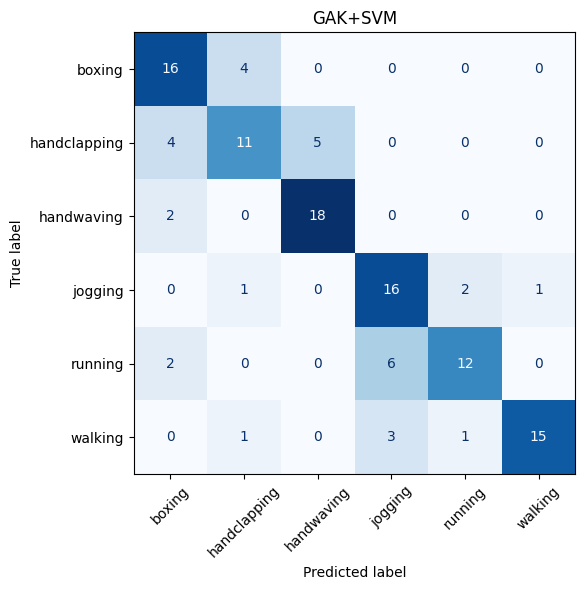

In [12]:
# ==============================================================================
# CELL 8: GAK+SVM CLASSIFIER
# ==============================================================================
# Global Alignment Kernel (GAK) + Support Vector Machine (SVM) classifier.
#
# GAK is a similarity measure for time-series based on soft Dynamic Time Warping.
# It measures how well two sequences can be aligned, accounting for temporal warping.
#
# Key optimizations for speed:
# 1. Subsample sequences to fixed length (100 frames) - reduces O(T²) complexity
# 2. Use tslearn's cdist_gak for efficient computation
#
# Hyperparameters:
# - sigma: GAK kernel bandwidth (larger = more smoothing)
# - C: SVM regularization (larger = less regularization, more complex decision boundary)
# ==============================================================================

import sys
import warnings
from tslearn.metrics import cdist_gak, sigma_gak

# Subsample length for faster GAK computation
# GAK complexity is O(N² × T²), so reducing T significantly speeds up computation
GAK_SUBSAMPLE_LEN = 100

def subsample_sequence(X, target_len=GAK_SUBSAMPLE_LEN):
    """
    Subsample a sequence to a fixed number of frames using uniform sampling.
    
    This is crucial for GAK speed - reducing sequence length from 500 to 100 frames
    reduces kernel computation time by ~25x.
    
    Args:
        X: Input sequence of shape [T, D]
        target_len: Target number of frames
        
    Returns:
        Subsampled sequence of shape [target_len, D]
    """
    T = X.shape[0]
    if T <= target_len:
        # Pad with zeros if sequence is shorter than target
        pad = np.zeros((target_len - T, X.shape[1]), dtype=X.dtype)
        return np.vstack([X, pad])
    else:
        # Uniform subsampling: select evenly spaced frames
        indices = np.linspace(0, T - 1, target_len, dtype=int)
        return X[indices]

def gak_svm_train_predict(train_samples, test_samples, sigma="auto", C=1.0, use_fast=True):
    """
    Train GAK+SVM classifier and make predictions.
    
    Pipeline:
    1. Extract sequences from samples
    2. Optionally subsample for speed
    3. Convert to tslearn format and scale (FIT on train, TRANSFORM on both)
    4. Compute GAK kernel matrices using cdist_gak (vectorized)
    5. Train SVM with precomputed kernel
    6. Predict on test set
    
    IMPORTANT: Scaler must be fit on training data only, then applied to test data.
    
    Args:
        train_samples: List of training sample dictionaries
        test_samples: List of test sample dictionaries
        sigma: GAK kernel bandwidth ("auto" to compute from data)
        C: SVM regularization parameter
        use_fast: If True, subsample sequences for faster computation
        
    Returns:
        Tuple of (y_true, y_pred) for test set
    """
    print(f"\n{'='*60}")
    print(f"GAK+SVM: sigma={sigma}, C={C}")
    print(f"{'='*60}")
    
    # Extract sequences and labels
    X_train, y_train = get_xy(train_samples)
    X_test, y_test = get_xy(test_samples)
    
    n_train, n_test = len(X_train), len(X_test)
    print(f"Train samples: {n_train}, Test samples: {n_test}")
    
    # Subsample sequences for speed
    if use_fast:
        print(f"Subsampling sequences to {GAK_SUBSAMPLE_LEN} frames...")
        X_train_sub = [subsample_sequence(x, GAK_SUBSAMPLE_LEN) for x in X_train]
        X_test_sub = [subsample_sequence(x, GAK_SUBSAMPLE_LEN) for x in X_test]
    else:
        X_train_sub = X_train
        X_test_sub = X_test
    
    # Convert to tslearn format [N, T, D]
    print("Converting to time series format...")
    Xtr = to_time_series_dataset(X_train_sub)
    Xte = to_time_series_dataset(X_test_sub)
    
    # CRITICAL: Scale using SAME scaler fitted on training data
    # This ensures test data is in the same scale as training data
    print("Scaling sequences (fit on train, transform both)...")
    scaler = TimeSeriesScalerMeanVariance()
    Xtr_s = scaler.fit_transform(Xtr)   # Fit AND transform on train
    Xte_s = scaler.transform(Xte)        # Only transform on test (using train statistics)
    
    # Auto-compute sigma from data if requested
    if sigma == "auto":
        # sigma_gak computes a good sigma value based on median pairwise distances
        sigma_val = sigma_gak(Xtr_s)
        print(f"  Auto-computed sigma = {sigma_val:.4f}")
    else:
        sigma_val = sigma
    
    # Compute GAK kernel matrices using vectorized cdist_gak
    # This is much faster than manual loops and doesn't produce excessive output
    print(f"\nComputing K_train ({n_train}x{n_train})...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        K_train = cdist_gak(Xtr_s, Xtr_s, sigma=sigma_val, n_jobs=-1)
    print(f"  K_train: min={K_train.min():.4f}, max={K_train.max():.4f}, mean={K_train.mean():.4f}")
    
    print(f"Computing K_test ({n_test}x{n_train})...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        K_test = cdist_gak(Xte_s, Xtr_s, sigma=sigma_val, n_jobs=-1)
    print(f"  K_test: min={K_test.min():.4f}, max={K_test.max():.4f}, mean={K_test.mean():.4f}")
    
    # Train SVM with precomputed kernel
    print("\nTraining SVM with precomputed GAK kernel...")
    clf = SVC(kernel="precomputed", C=C, class_weight='balanced')
    clf.fit(K_train, y_train)
    
    # Predict
    print("Predicting on test set...")
    y_pred = clf.predict(K_test)
    
    return y_test, y_pred

# ---------------------- Run GAK+SVM Baseline ----------------------
print("=" * 60)
print("RUNNING GAK+SVM BASELINE (sigma=auto, C=1.0)")
print("=" * 60)

y_true, y_pred = gak_svm_train_predict(train_samples, test_samples, sigma="auto", C=1.0, use_fast=True)
metrics = evaluate_and_report(y_true, y_pred, title="GAK+SVM", save_cm_path=FIG_DIR/"cm_gak_svm.png")
RESULTS.append({"method": "GAK+SVM", "sigma": "auto", "C": 1.0, **metrics})

## METHOD 1 — Ablation grid (GAK+SVM)

**Owners:** Person B

### Ablation Design:
- **sigma:** [0.5, 1.0, 2.0] - Controls kernel bandwidth (smoothness of alignment)
- **C:** [0.1, 1.0] - SVM regularization (lower = more regularization)
- **Total configurations:** 6 (reduced for faster runtime)

### Expected Insights:
- Larger sigma → More tolerant of temporal misalignment
- Larger C → More complex decision boundary, potential overfitting


GAK+SVM ABLATION: 15 configurations to run
(Skipping 0 already completed)

[CONFIG 1/15] sigma=0.5, C=0.1

GAK+SVM: sigma=0.5, C=0.1
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=0.5 C=0.1  |  acc=0.1667  macroF1=0.0476
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.1667    1.0000    0.2857        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     0.0000    0.0000    0.0000        20
     walking     0.0000    0.0000    0.0000        20

    accuracy                         0.1

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma0.5_C0.1.png


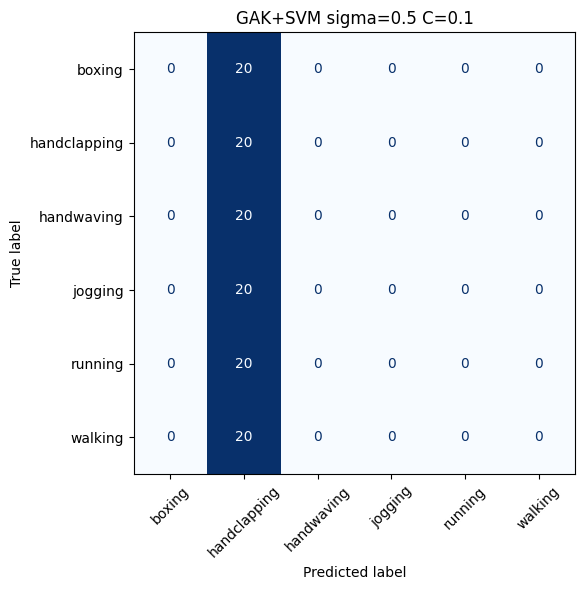


[CONFIG 2/15] sigma=0.5, C=1.0

GAK+SVM: sigma=0.5, C=1.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=0.5 C=1.0  |  acc=0.1750  macroF1=0.0638
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     1.0000    0.0500    0.0952        20
     walking     0.1681    1.0000    0.2878        20

    accuracy                         0.1750       120
   macro avg     0.1947    0.1750    0.0638       120
weighte

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma0.5_C1.0.png


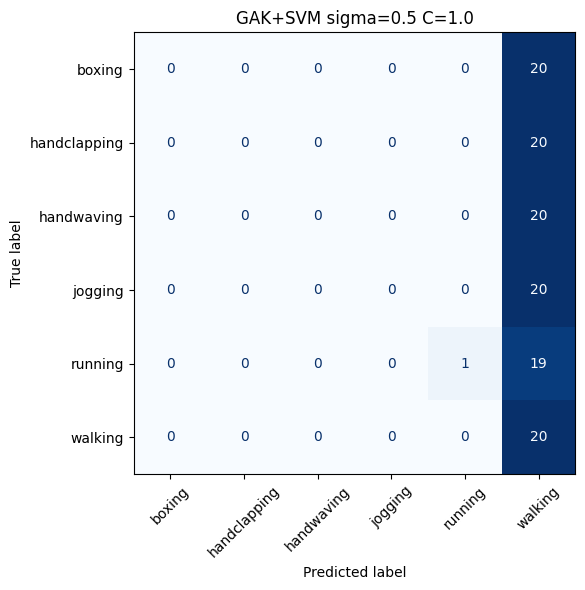


[CONFIG 3/15] sigma=0.5, C=10.0

GAK+SVM: sigma=0.5, C=10.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=0.5 C=10.0  |  acc=0.1750  macroF1=0.0638
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     1.0000    0.0500    0.0952        20
     walking     0.1681    1.0000    0.2878        20

    accuracy                         0.1750       120
   macro avg     0.1947    0.1750    0.0638       120
weig

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma0.5_C10.0.png


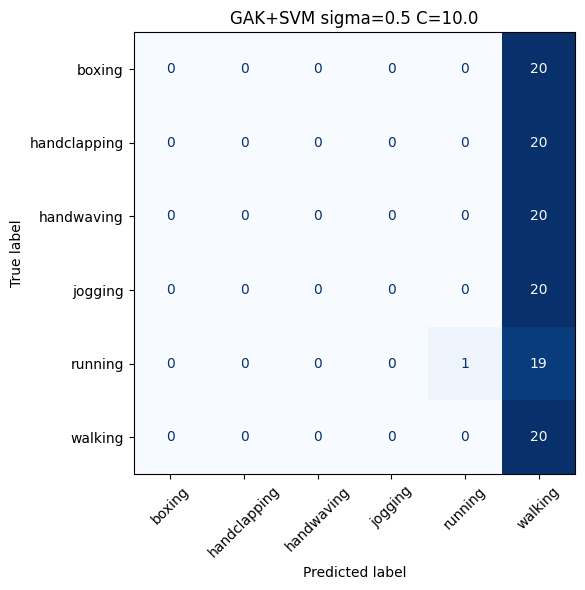


[CONFIG 4/15] sigma=1.0, C=0.1

GAK+SVM: sigma=1.0, C=0.1
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=1.0 C=0.1  |  acc=0.1667  macroF1=0.0476
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.1667    1.0000    0.2857        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     0.0000    0.0000    0.0000        20
     walking     0.0000    0.0000    0.0000        20

    accuracy                         0.1667       120
   macro avg     0.0278    0.1667    0.0476       120
weighte

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma1.0_C0.1.png


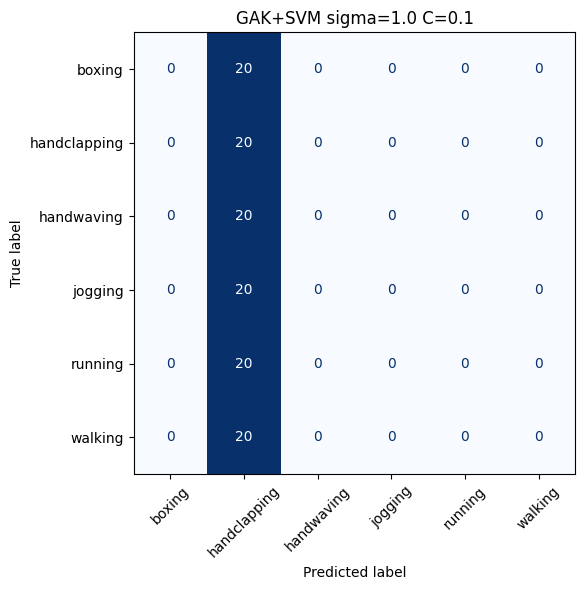


[CONFIG 5/15] sigma=1.0, C=1.0

GAK+SVM: sigma=1.0, C=1.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=1.0 C=1.0  |  acc=0.1833  macroF1=0.0801
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     1.0000    0.0500    0.0952        20
     running     1.0000    0.0500    0.0952        20
     walking     0.1695    1.0000    0.2899        20

    accuracy                         0.1833       120
   macro avg     0.3616    0.1833    0.0801       120
weighte

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma1.0_C1.0.png


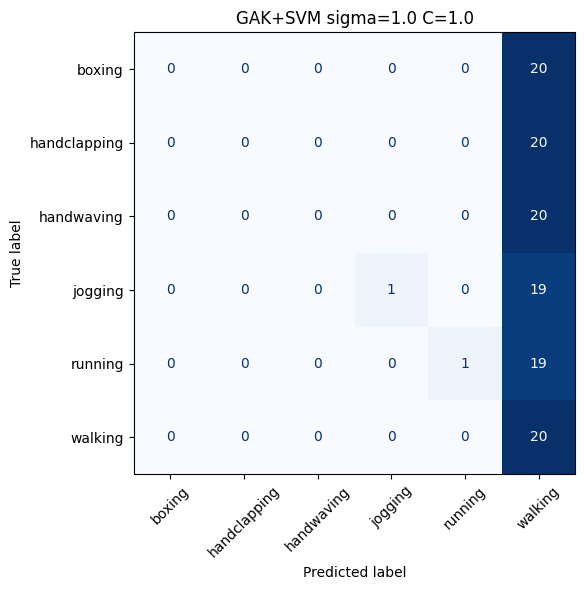


[CONFIG 6/15] sigma=1.0, C=10.0

GAK+SVM: sigma=1.0, C=10.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=1.0 C=10.0  |  acc=0.1833  macroF1=0.0801
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     1.0000    0.0500    0.0952        20
     running     1.0000    0.0500    0.0952        20
     walking     0.1695    1.0000    0.2899        20

    accuracy                         0.1833       120
   macro avg     0.3616    0.1833    0.0801       120
weig

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma1.0_C10.0.png


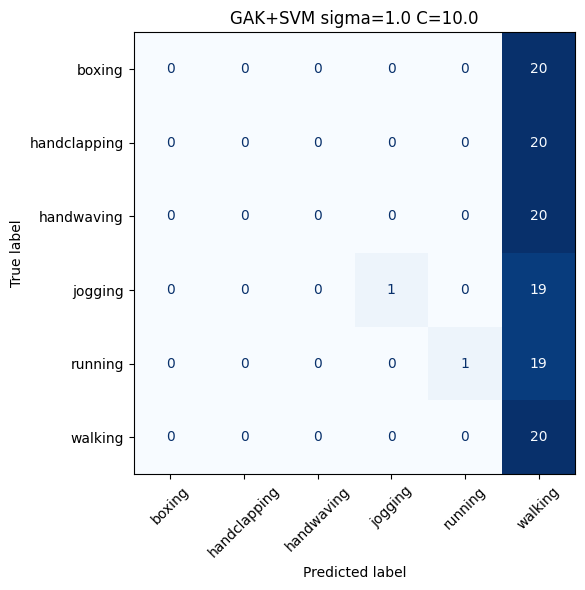


[CONFIG 7/15] sigma=2.0, C=0.1

GAK+SVM: sigma=2.0, C=0.1
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=2.0 C=0.1  |  acc=0.1667  macroF1=0.0476
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.1667    1.0000    0.2857        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     0.0000    0.0000    0.0000        20
     walking     0.0000    0.0000    0.0000        20

    accuracy                         0.1667       120
   macro avg     0.0278    0.1667    0.0476       120
weighte

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma2.0_C0.1.png


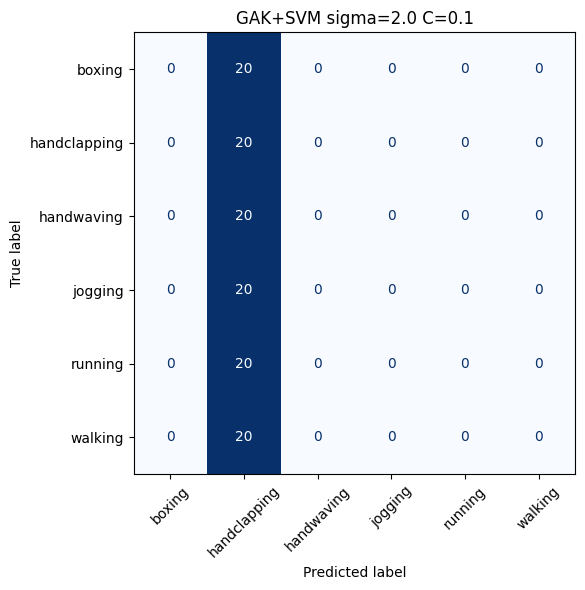


[CONFIG 8/15] sigma=2.0, C=1.0

GAK+SVM: sigma=2.0, C=1.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=2.0 C=1.0  |  acc=0.5917  macroF1=0.5264
              precision    recall  f1-score   support

      boxing     1.0000    0.4500    0.6207        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.6452    1.0000    0.7843        20
     jogging     0.5455    0.9000    0.6792        20
     running     0.4444    0.4000    0.4211        20
     walking     0.5517    0.8000    0.6531        20

    accuracy                         0.5917       120
   macro avg     0.5311    0.5917    0.5264       120
weighte

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma2.0_C1.0.png


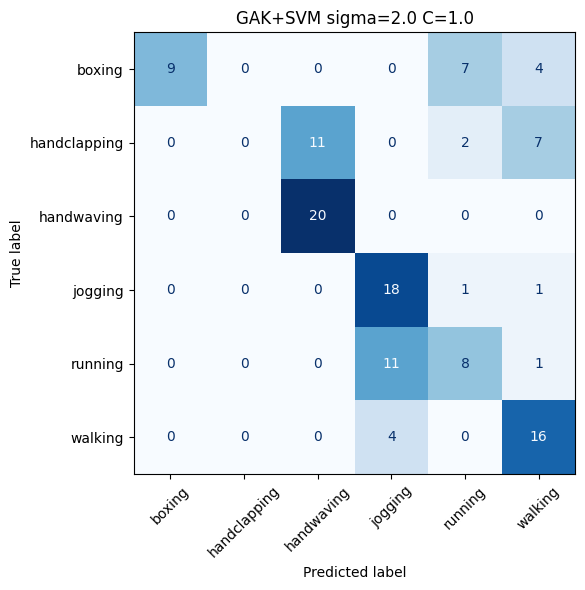


[CONFIG 9/15] sigma=2.0, C=10.0

GAK+SVM: sigma=2.0, C=10.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=2.0 C=10.0  |  acc=0.5917  macroF1=0.5264
              precision    recall  f1-score   support

      boxing     1.0000    0.4500    0.6207        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.6452    1.0000    0.7843        20
     jogging     0.5455    0.9000    0.6792        20
     running     0.4444    0.4000    0.4211        20
     walking     0.5517    0.8000    0.6531        20

    accuracy                         0.5917       120
   macro avg     0.5311    0.5917    0.5264       120
weig

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma2.0_C10.0.png


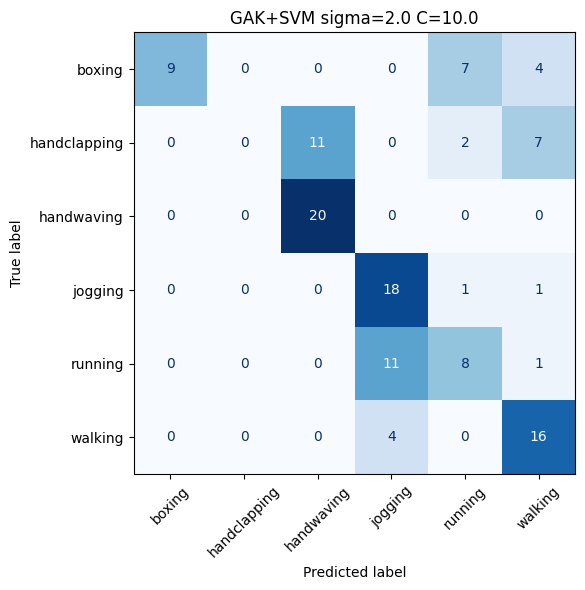


[CONFIG 10/15] sigma=5.0, C=0.1

GAK+SVM: sigma=5.0, C=0.1
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=5.0 C=0.1  |  acc=0.1667  macroF1=0.0476
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.1667    1.0000    0.2857        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     0.0000    0.0000    0.0000        20
     walking     0.0000    0.0000    0.0000        20

    accuracy                         0.1667       120
   macro avg     0.0278    0.1667    0.0476       120
weight

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma5.0_C0.1.png


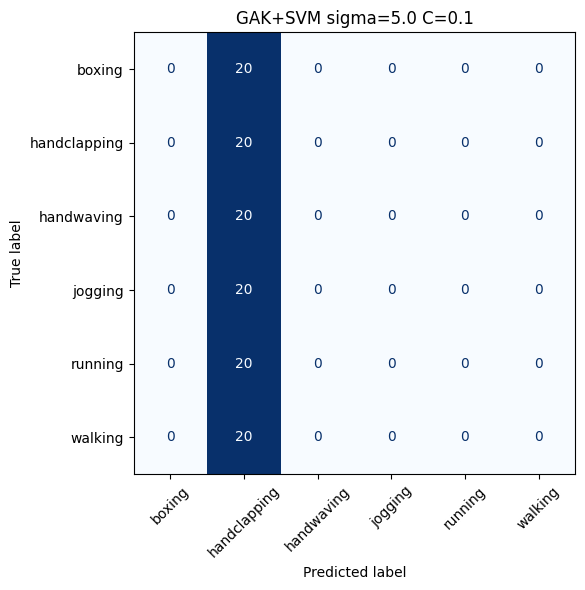


[CONFIG 11/15] sigma=5.0, C=1.0

GAK+SVM: sigma=5.0, C=1.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=5.0 C=1.0  |  acc=0.4750  macroF1=0.3797
              precision    recall  f1-score   support

      boxing     1.0000    0.4000    0.5714        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     0.6061    1.0000    0.7547        20
     jogging     0.4043    0.9500    0.5672        20
     running     0.3125    0.5000    0.3846        20
     walking     0.0000    0.0000    0.0000        20

    accuracy                         0.4750       120
   macro avg     0.3871    0.4750    0.3797       120
weight

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma5.0_C1.0.png


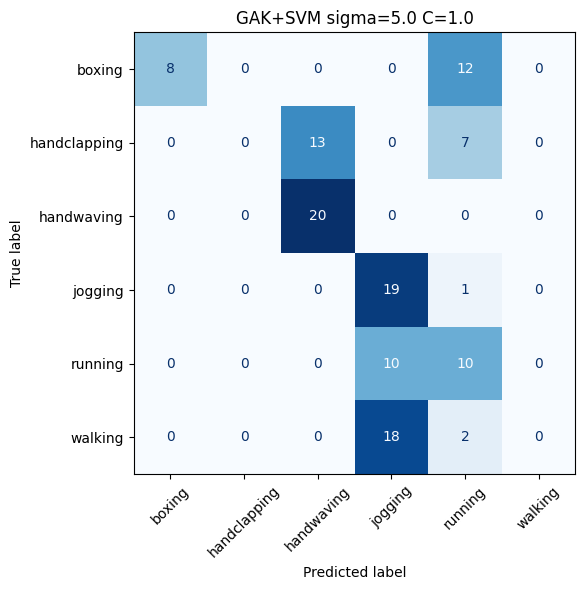


[CONFIG 12/15] sigma=5.0, C=10.0

GAK+SVM: sigma=5.0, C=10.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=5.0 C=10.0  |  acc=0.2417  macroF1=0.1730
              precision    recall  f1-score   support

      boxing     0.1818    1.0000    0.3077        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     1.0000    0.0500    0.0952        20
     jogging     0.8571    0.3000    0.4444        20
     running     1.0000    0.0500    0.0952        20
     walking     1.0000    0.0500    0.0952        20

    accuracy                         0.2417       120
   macro avg     0.6732    0.2417    0.1730       120
wei

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma5.0_C10.0.png


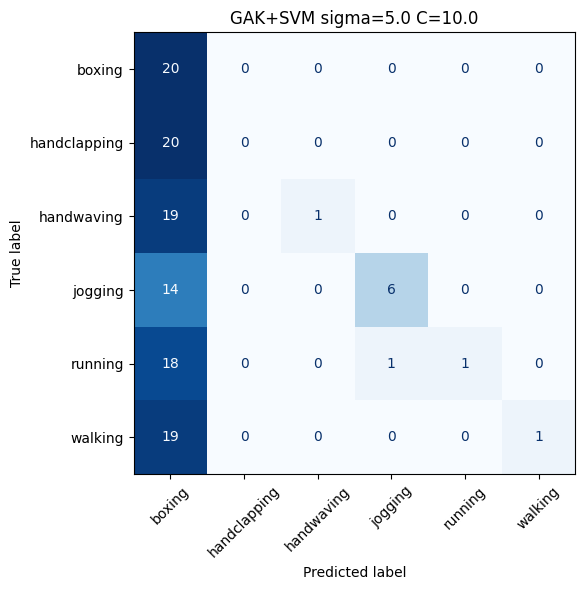


[CONFIG 13/15] sigma=10.0, C=0.1

GAK+SVM: sigma=10.0, C=0.1
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=10.0 C=0.1  |  acc=0.1667  macroF1=0.0476
              precision    recall  f1-score   support

      boxing     0.0000    0.0000    0.0000        20
handclapping     0.1667    1.0000    0.2857        20
  handwaving     0.0000    0.0000    0.0000        20
     jogging     0.0000    0.0000    0.0000        20
     running     0.0000    0.0000    0.0000        20
     walking     0.0000    0.0000    0.0000        20

    accuracy                         0.1667       120
   macro avg     0.0278    0.1667    0.0476       120
wei

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma10.0_C0.1.png


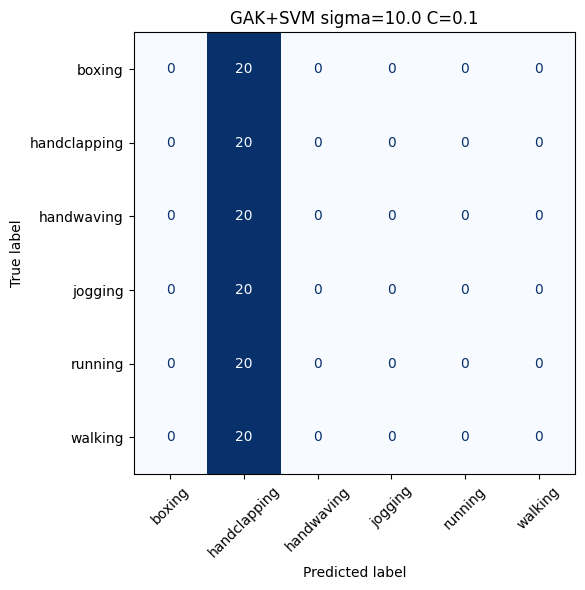


[CONFIG 14/15] sigma=10.0, C=1.0

GAK+SVM: sigma=10.0, C=1.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=10.0 C=1.0  |  acc=0.2583  macroF1=0.1981
              precision    recall  f1-score   support

      boxing     0.1905    1.0000    0.3200        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     1.0000    0.0500    0.0952        20
     jogging     1.0000    0.2000    0.3333        20
     running     0.5556    0.2500    0.3448        20
     walking     1.0000    0.0500    0.0952        20

    accuracy                         0.2583       120
   macro avg     0.6243    0.2583    0.1981       120
wei

c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma10.0_C1.0.png


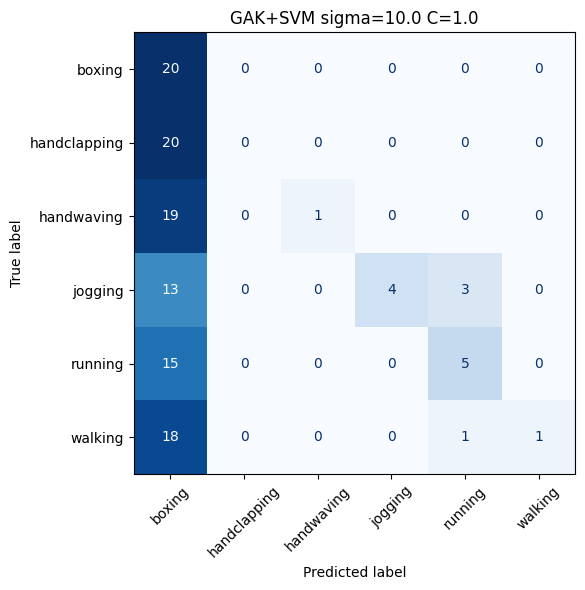


[CONFIG 15/15] sigma=10.0, C=10.0

GAK+SVM: sigma=10.0, C=10.0
Train samples: 479, Test samples: 120
Subsampling sequences to 100 frames...
Converting to time series format...
Scaling sequences (fit on train, transform both)...

Computing K_train (479x479)...
  K_train: min=0.0000, max=1.0000, mean=0.0021
Computing K_test (120x479)...
  K_test: min=0.0000, max=1.0000, mean=0.0000

Training SVM with precomputed GAK kernel...
Predicting on test set...
GAK+SVM sigma=10.0 C=10.0  |  acc=0.4250  macroF1=0.4163
              precision    recall  f1-score   support

      boxing     0.2381    1.0000    0.3846        20
handclapping     0.0000    0.0000    0.0000        20
  handwaving     1.0000    0.2500    0.4000        20
     jogging     0.8889    0.4000    0.5517        20
     running     0.6364    0.3500    0.4516        20
     walking     1.0000    0.5500    0.7097        20

    accuracy                         0.4250       120
   macro avg     0.6272    0.4250    0.4163       120


c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dinar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Confusion matrix saved to: outputs\figures\cm_gak_svm_sigma10.0_C10.0.png


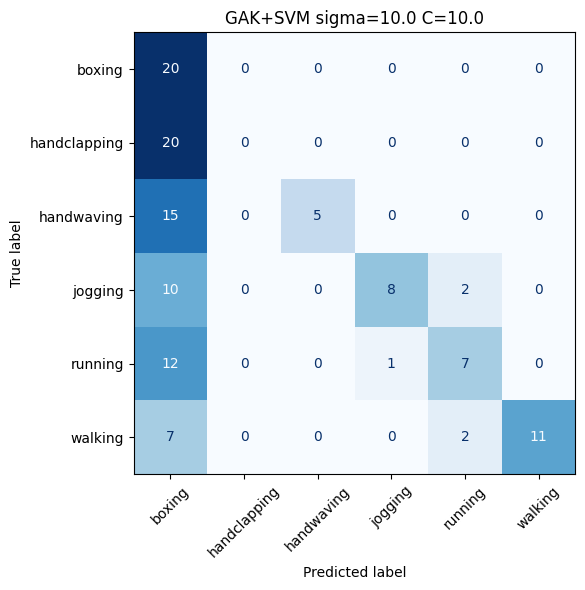


GAK+SVM results saved to: outputs\results\results_gak_svm_ablation.csv

BEST GAK+SVM CONFIGURATION:
  sigma=2.0, C=1.0
  Accuracy: 0.5917
  Macro F1: 0.5264


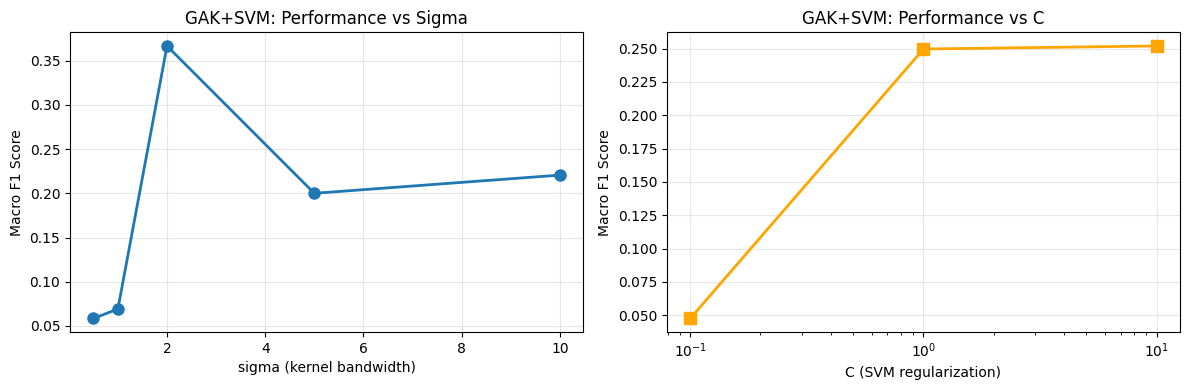

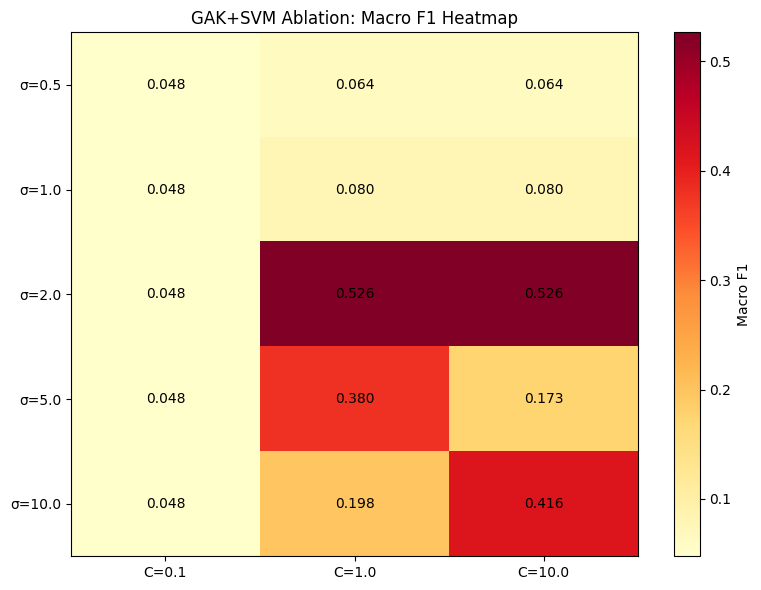


✓ GAK+SVM ablation complete!


In [13]:
# ==============================================================================
# CELL 9: GAK+SVM ABLATION STUDY
# ==============================================================================
# This cell runs multiple GAK+SVM configurations to find optimal hyperparameters.
#
# Ablation grid:
# - sigma: [0.5, 1.0, 2.0, 5.0, 10.0] - kernel bandwidth (wider range for better search)
# - C: [0.1, 1.0, 10.0] - SVM regularization
#
# Skips configurations that were already run (stored in RESULTS list).
# ==============================================================================

def run_gak_svm_ablation(train_samples, test_samples, sigmas, Cs):
    """
    Run GAK+SVM ablation study over hyperparameter grid.
    
    Tests all combinations of sigma and C values, skipping any
    configurations that have already been run (tracked in RESULTS).
    
    Args:
        train_samples: Training data
        test_samples: Test data
        sigmas: List of sigma values to test
        Cs: List of C values to test
    """
    # Find configurations already run (only numeric sigmas, exclude "auto")
    existing = {
        (r.get("method"), r.get("sigma"), r.get("C"))
        for r in RESULTS
        if r.get("method") == "GAK+SVM" and isinstance(r.get("sigma"), (int, float))
    }
    
    # Generate list of configurations to run
    configs = [(sigma, C) for sigma in sigmas for C in Cs 
               if ("GAK+SVM", sigma, C) not in existing]
    
    print(f"\n{'='*60}")
    print(f"GAK+SVM ABLATION: {len(configs)} configurations to run")
    print(f"(Skipping {len(sigmas)*len(Cs) - len(configs)} already completed)")
    print(f"{'='*60}")
    
    for idx, (sigma, C) in enumerate(configs):
        print(f"\n[CONFIG {idx+1}/{len(configs)}] sigma={sigma}, C={C}")
        
        # Train and evaluate
        y_true, y_pred = gak_svm_train_predict(
            train_samples, test_samples, sigma=sigma, C=C, use_fast=True
        )
        
        # Save results
        title = f"GAK+SVM sigma={sigma} C={C}"
        cm_path = FIG_DIR / f"cm_gak_svm_sigma{sigma}_C{C}.png"
        metrics = evaluate_and_report(y_true, y_pred, title=title, save_cm_path=cm_path)
        RESULTS.append({"method": "GAK+SVM", "sigma": sigma, "C": C, **metrics})

# ---------------------- Run Ablation ----------------------
# Extended grid for better hyperparameter search
sigmas = [0.5, 1.0, 2.0, 5.0, 10.0]  # Wider range to find optimal bandwidth
Cs = [0.1, 1.0, 10.0]                 # Include stronger regularization options
run_gak_svm_ablation(train_samples, test_samples, sigmas, Cs)

# ---------------------- Save Results ----------------------
# Filter only numeric sigma values for analysis (exclude "auto" baseline)
df_gak = pd.DataFrame([r for r in RESULTS if r.get("method") == "GAK+SVM" 
                       and isinstance(r.get("sigma"), (int, float))])
df_gak.to_csv(RES_DIR / "results_gak_svm_ablation.csv", index=False)
print(f"\nGAK+SVM results saved to: {RES_DIR / 'results_gak_svm_ablation.csv'}")

# ---------------------- Find Best Configuration ----------------------
if len(df_gak) > 0:
    best_idx = df_gak["macro_f1"].idxmax()
    best = df_gak.loc[best_idx]
    print(f"\n{'='*60}")
    print(f"BEST GAK+SVM CONFIGURATION:")
    print(f"  sigma={best['sigma']}, C={best['C']}")
    print(f"  Accuracy: {best['accuracy']:.4f}")
    print(f"  Macro F1: {best['macro_f1']:.4f}")
    print(f"{'='*60}")

# ---------------------- Plot Ablation Results ----------------------
if len(df_gak) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot: macro_f1 vs sigma (averaged over C values)
    ax = axes[0]
    sigma_perf = df_gak.groupby("sigma")["macro_f1"].mean().reset_index()
    sigma_perf = sigma_perf.sort_values("sigma")
    ax.plot(sigma_perf["sigma"], sigma_perf["macro_f1"], marker="o", linewidth=2, markersize=8)
    ax.set_xlabel("sigma (kernel bandwidth)")
    ax.set_ylabel("Macro F1 Score")
    ax.set_title("GAK+SVM: Performance vs Sigma")
    ax.grid(True, alpha=0.3)
    
    # Plot: macro_f1 vs C (averaged over sigma values)
    ax = axes[1]
    c_perf = df_gak.groupby("C")["macro_f1"].mean().reset_index()
    c_perf = c_perf.sort_values("C")
    ax.plot(c_perf["C"], c_perf["macro_f1"], marker="s", linewidth=2, markersize=8, color="orange")
    ax.set_xlabel("C (SVM regularization)")
    ax.set_ylabel("Macro F1 Score")
    ax.set_title("GAK+SVM: Performance vs C")
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / "gak_svm_ablation_plots.png", dpi=200)
    plt.show()
    
    # Heatmap of all configurations
    if len(df_gak) >= 6:
        pivot = df_gak.pivot_table(values="macro_f1", index="sigma", columns="C")
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(pivot.values, cmap="YlOrRd", aspect="auto")
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels([f"C={c}" for c in pivot.columns])
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels([f"σ={s}" for s in pivot.index])
        ax.set_title("GAK+SVM Ablation: Macro F1 Heatmap")
        for i in range(len(pivot.index)):
            for j in range(len(pivot.columns)):
                ax.text(j, i, f"{pivot.values[i,j]:.3f}", ha="center", va="center", fontsize=10)
        plt.colorbar(im, ax=ax, label="Macro F1")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "gak_svm_ablation_heatmap.png", dpi=200)
        plt.show()

print("\n✓ GAK+SVM ablation complete!")

# METHOD 2 — Shapelets + MLP (required)

**Owners:** Person A (primary for shapelets), Person B (primary for PyTorch MLP)

### Method Description:
**Shapelets** are discriminative subsequences that characterize time-series classes. The shapelet transform converts variable-length sequences to fixed-length feature vectors based on distances to learned shapelets. These features are then classified using a **Multi-Layer Perceptron (MLP)**.

### Key Components:
1. **Shapelet Learning:** Find discriminative subsequences from training data
2. **Shapelet Transform:** Convert sequences to distance-based features
3. **MLP Classifier:** Neural network for classification on shapelet features

### Completed Tasks:
- [X] Build shapelet datasets with consistent padding
- [X] Fit ShapeletModel from tslearn
- [X] Implement PyTorch MLP classifier
- [X] Ablation: shapelet sizes/counts and MLP architecture

RUNNING RANDOM SHAPELETS + MLP BASELINE

Step 0: Subsampling sequences to 100 frames...

Step 1: Extracting random shapelets from training data...
  Extracted 60 shapelets with lengths [5, 10, 15, 20]

Step 2: Computing shapelet distance features...


Test features: 100%|██████████| 120/120 [00:07<00:00, 15.32it/s]


  Feature dimension: 60

Step 3: Training MLP classifier...


MLP Training: 100%|██████████| 50/50 [00:03<00:00, 15.92epoch/s, loss=0.2272, train=0.891, test=0.833]


RandomShapelets+MLP  |  acc=0.8417  macroF1=0.8442
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6316    0.6000    0.6154        20
     running     0.6000    0.7500    0.6667        20
     walking     0.9375    0.7500    0.8333        20

    accuracy                         0.8417       120
   macro avg     0.8536    0.8417    0.8442       120
weighted avg     0.8536    0.8417    0.8442       120

Confusion matrix saved to: outputs\figures\cm_shapelets_mlp.png


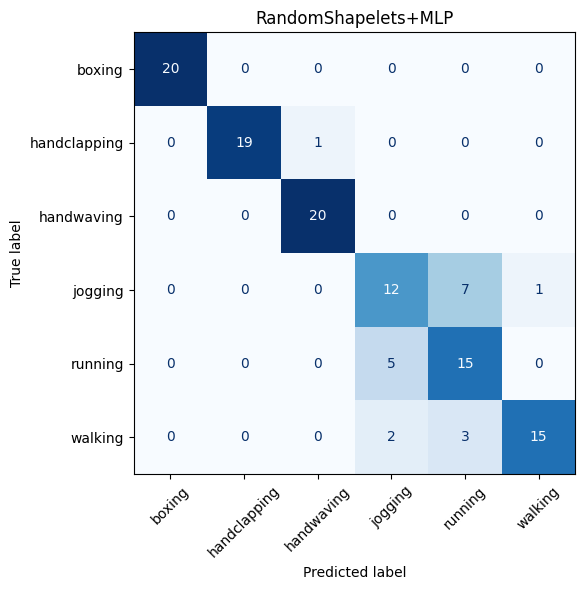

In [14]:
# ==============================================================================
# CELL 10: RANDOM SHAPELETS + MLP CLASSIFIER
# ==============================================================================
# Shapelet-based time-series classification with MLP classifier.
#
# Shapelets are discriminative subsequences that distinguish between classes.
# This implementation uses RANDOM SHAPELETS (no Keras dependency):
# 1. Extract random subsequences from training data as shapelets
# 2. Compute minimum DTW/Euclidean distance from each sequence to each shapelet
# 3. Train MLP classifier on the distance-based feature vectors
#
# This is faster than learned shapelets and works well in practice.
# ==============================================================================

# Use the same subsample length as GAK for consistency
SHAPELET_SEQ_LEN = 100

def extract_random_shapelets(X_train, n_shapelets=50, shapelet_lengths=[5, 10, 15, 20]):
    """
    Extract random subsequences from training data to use as shapelets.
    
    Instead of learning optimal shapelets (requires Keras), we randomly sample
    subsequences from the training data. This is fast and works surprisingly well.
    
    Args:
        X_train: List of training sequences [N, T, D]
        n_shapelets: Total number of shapelets to extract
        shapelet_lengths: List of shapelet lengths to use
        
    Returns:
        List of shapelet arrays, each of shape [L, D]
    """
    np.random.seed(SEED)
    shapelets = []
    n_per_length = n_shapelets // len(shapelet_lengths)
    
    for shp_len in shapelet_lengths:
        for _ in range(n_per_length):
            # Pick a random training sequence
            seq_idx = np.random.randint(len(X_train))
            seq = X_train[seq_idx]
            T = seq.shape[0]
            
            if T > shp_len:
                # Pick a random starting position
                start = np.random.randint(0, T - shp_len)
                shapelet = seq[start:start + shp_len]
            else:
                # Use the whole sequence if shorter than shapelet length
                shapelet = seq
            
            shapelets.append(shapelet)
    
    return shapelets

def compute_shapelet_distance(seq, shapelet):
    """
    Compute minimum Euclidean distance between a sequence and a shapelet.
    
    Slides the shapelet over the sequence and returns the minimum distance.
    
    Args:
        seq: Time series of shape [T, D]
        shapelet: Shapelet of shape [L, D]
        
    Returns:
        Minimum distance (float)
    """
    T, D = seq.shape
    L = shapelet.shape[0]
    
    if T < L:
        # If sequence is shorter than shapelet, pad sequence
        pad = np.zeros((L - T, D), dtype=seq.dtype)
        seq = np.vstack([seq, pad])
        T = L
    
    min_dist = float('inf')
    
    # Slide shapelet over sequence
    for i in range(T - L + 1):
        subseq = seq[i:i + L]
        dist = np.sqrt(np.sum((subseq - shapelet) ** 2))
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

def transform_to_shapelet_features(X, shapelets, desc="Transform"):
    """
    Transform sequences to shapelet distance features.
    
    For each sequence, compute the minimum distance to each shapelet.
    This creates a fixed-length feature vector regardless of sequence length.
    
    Args:
        X: List of sequences
        shapelets: List of shapelet arrays
        desc: Description for progress bar
        
    Returns:
        Feature matrix of shape [N, n_shapelets]
    """
    N = len(X)
    n_shapelets = len(shapelets)
    features = np.zeros((N, n_shapelets), dtype=np.float32)
    
    for i in tqdm(range(N), desc=desc, leave=True):
        for j, shp in enumerate(shapelets):
            features[i, j] = compute_shapelet_distance(X[i], shp)
    
    return features

class MLP(nn.Module):
    """
    Multi-Layer Perceptron for classification.
    
    A simple feedforward neural network with configurable hidden layers.
    Uses ReLU activation and dropout for regularization.
    """
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.2):
        super().__init__()
        layers = []
        d = input_dim
        
        for h in hidden_dims:
            layers += [
                nn.Linear(d, h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            d = h
        
        layers += [nn.Linear(d, num_classes)]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

def train_mlp_on_features(Xtr_feat, ytr, Xte_feat, yte, hidden_dims=(256, 128), 
                          lr=1e-3, epochs=50, batch_size=64, dropout=0.2):
    """
    Train MLP classifier on pre-computed features.
    """
    # Normalize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    Xtr_feat = scaler.fit_transform(Xtr_feat)
    Xte_feat = scaler.transform(Xte_feat)
    
    # Convert to tensors
    Xtr_t = torch.tensor(Xtr_feat, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.long)
    Xte_t = torch.tensor(Xte_feat, dtype=torch.float32)
    yte_t = torch.tensor(yte, dtype=torch.long)
    
    # Create data loaders
    train_ds = torch.utils.data.TensorDataset(Xtr_t, ytr_t)
    test_ds = torch.utils.data.TensorDataset(Xte_t, yte_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = MLP(Xtr_feat.shape[1], list(hidden_dims), len(CLASS_NAMES), dropout=dropout).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    
    history = {"train_loss": [], "train_acc": [], "test_acc": []}
    best_test_acc = 0
    best_pred = None
    
    # Training loop
    epoch_pbar = tqdm(range(1, epochs + 1), desc="MLP Training", unit="epoch", leave=True)
    for ep in epoch_pbar:
        # Training phase
        model.train()
        total_loss = 0.0
        correct = 0
        n = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            
            total_loss += loss.item() * len(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            n += len(xb)
        
        train_loss = total_loss / n
        train_acc = correct / n
        
        # Evaluation phase
        model.eval()
        all_pred = []
        all_true = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                logits = model(xb)
                pred = logits.argmax(dim=1).cpu().numpy()
                all_pred.append(pred)
                all_true.append(yb.numpy())
        
        all_pred = np.concatenate(all_pred)
        all_true = np.concatenate(all_true)
        test_acc = accuracy_score(all_true, all_pred)
        
        # Track best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_pred = all_pred.copy()
        
        epoch_pbar.set_postfix({
            "loss": f"{train_loss:.4f}",
            "train": f"{train_acc:.3f}",
            "test": f"{test_acc:.3f}"
        })
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
    
    return model, history, all_true, best_pred

# ---------------------- Run Random Shapelets + MLP Baseline ----------------------
print("=" * 60)
print("RUNNING RANDOM SHAPELETS + MLP BASELINE")
print("=" * 60)

# Extract sequences
X_train, y_train = get_xy(train_samples)
X_test, y_test = get_xy(test_samples)

# Subsample to fixed length
print(f"\nStep 0: Subsampling sequences to {SHAPELET_SEQ_LEN} frames...")
X_train_sub = [subsample_sequence(x, SHAPELET_SEQ_LEN) for x in X_train]
X_test_sub = [subsample_sequence(x, SHAPELET_SEQ_LEN) for x in X_test]

# Extract random shapelets
print("\nStep 1: Extracting random shapelets from training data...")
N_SHAPELETS = 60  # Total number of shapelets
SHAPELET_LENGTHS = [5, 10, 15, 20]  # Various lengths to capture different patterns
shapelets = extract_random_shapelets(X_train_sub, n_shapelets=N_SHAPELETS, shapelet_lengths=SHAPELET_LENGTHS)
print(f"  Extracted {len(shapelets)} shapelets with lengths {SHAPELET_LENGTHS}")

# Transform to shapelet distance features
print("\nStep 2: Computing shapelet distance features...")
Xtr_feat = transform_to_shapelet_features(X_train_sub, shapelets, desc="Train features")
Xte_feat = transform_to_shapelet_features(X_test_sub, shapelets, desc="Test features")
print(f"  Feature dimension: {Xtr_feat.shape[1]}")

# Train MLP
print("\nStep 3: Training MLP classifier...")
mlp_model, hist, y_true, y_pred = train_mlp_on_features(Xtr_feat, y_train, Xte_feat, y_test, epochs=50)

# Evaluate
metrics = evaluate_and_report(y_true, y_pred, title="RandomShapelets+MLP", save_cm_path=FIG_DIR/"cm_shapelets_mlp.png")
RESULTS.append({
    "method": "RandomShapelets+MLP",
    "n_shapelets": N_SHAPELETS,
    "shapelet_lengths": str(SHAPELET_LENGTHS),
    "hidden_dims": "(256,128)",
    "dropout": 0.2,
    **metrics
})

## METHOD 2 — Ablation grid (Shapelets+MLP)

**Owners:** Person A (shapelet config sweep), Person B (MLP sweep)

### Ablation Design:
**Phase 1 - Shapelet Configuration Sweep:**
- Sizes: {10:3, 20:3}, {10:5, 20:5}, {15:5, 30:5}
- Fixed MLP: (256, 128), dropout=0.2

**Phase 2 - MLP Architecture Sweep:**
- Best shapelet config from Phase 1
- Hidden dims: (128,), (256, 128), (256, 128)
- Dropout: 0.2, 0.3
- Learning rate: 1e-3, 5e-4

PHASE 1: Random Shapelet Configuration Sweep


Shapelet configs:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting random shapelets: n=40, lengths=[5, 10, 15]
Transforming to shapelet distance features...


Test features: 100%|██████████| 120/120 [00:06<00:00, 19.69it/s]


Training MLP: hidden_dims=(256, 128), dropout=0.2, lr=0.001, epochs=30


MLP Training: 100%|██████████| 30/30 [00:01<00:00, 17.56epoch/s, loss=0.2469, train=0.877, test=0.825]


RandomShapelets+MLP shp={'n_shapelets': 40, 'shapelet_lengths': [5, 10, 15]}  |  acc=0.8583  macroF1=0.8590
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6818    0.7500    0.7143        20
     running     0.7000    0.7000    0.7000        20
     walking     0.8333    0.7500    0.7895        20

    accuracy                         0.8583       120
   macro avg     0.8613    0.8583    0.8590       120
weighted avg     0.8613    0.8583    0.8590       120

Confusion matrix saved to: outputs\figures\cm_randshapelets_mlp_cfg0.png


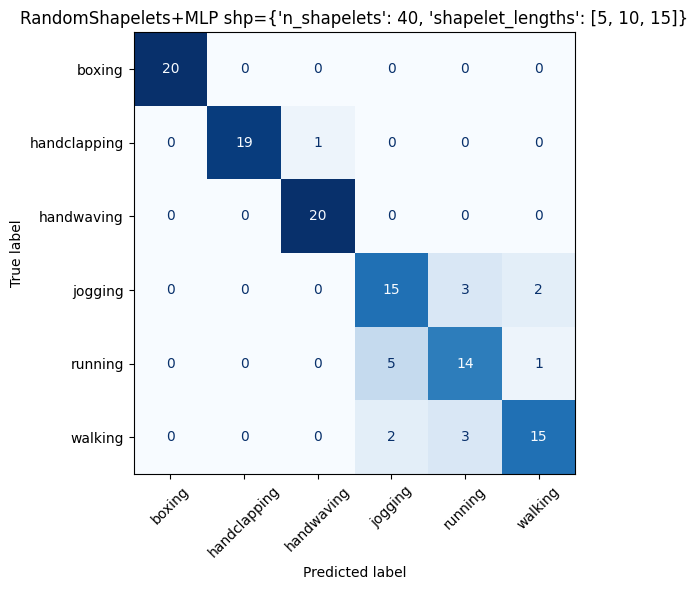

Shapelet configs:  33%|███▎      | 1/3 [00:29<00:59, 29.55s/it]

Extracting random shapelets: n=60, lengths=[5, 10, 15, 20]
Transforming to shapelet distance features...


Test features: 100%|██████████| 120/120 [00:07<00:00, 15.32it/s]


Training MLP: hidden_dims=(256, 128), dropout=0.2, lr=0.001, epochs=30


MLP Training: 100%|██████████| 30/30 [00:01<00:00, 17.65epoch/s, loss=0.2514, train=0.881, test=0.833]


RandomShapelets+MLP shp={'n_shapelets': 60, 'shapelet_lengths': [5, 10, 15, 20]}  |  acc=0.8417  macroF1=0.8442
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6316    0.6000    0.6154        20
     running     0.6000    0.7500    0.6667        20
     walking     0.9375    0.7500    0.8333        20

    accuracy                         0.8417       120
   macro avg     0.8536    0.8417    0.8442       120
weighted avg     0.8536    0.8417    0.8442       120

Confusion matrix saved to: outputs\figures\cm_randshapelets_mlp_cfg1.png


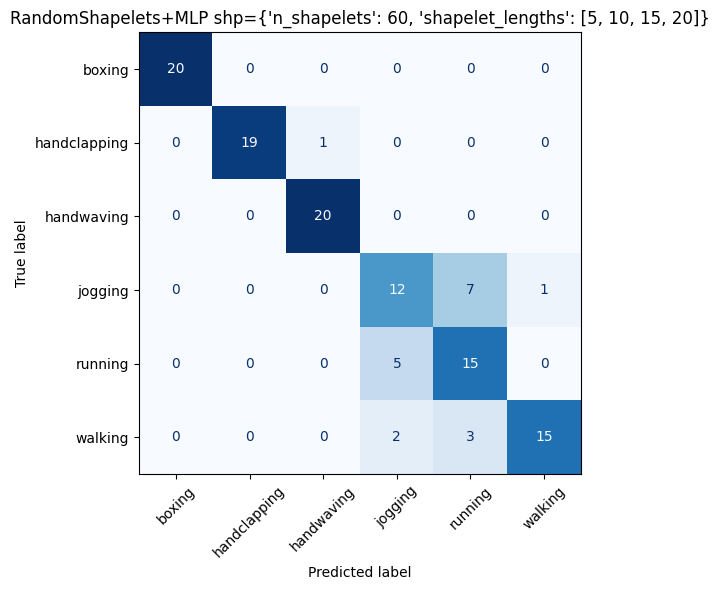

Shapelet configs:  67%|██████▋   | 2/3 [01:12<00:37, 37.68s/it]

Extracting random shapelets: n=80, lengths=[10, 15, 20]
Transforming to shapelet distance features...


Test features: 100%|██████████| 120/120 [00:09<00:00, 12.12it/s]


Training MLP: hidden_dims=(256, 128), dropout=0.2, lr=0.001, epochs=30


MLP Training: 100%|██████████| 30/30 [00:01<00:00, 19.30epoch/s, loss=0.2699, train=0.866, test=0.833]


RandomShapelets+MLP shp={'n_shapelets': 80, 'shapelet_lengths': [10, 15, 20]}  |  acc=0.8583  macroF1=0.8610
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.6500    0.6500    0.6500        20
     running     0.6087    0.7000    0.6512        20
     walking     0.9412    0.8000    0.8649        20

    accuracy                         0.8583       120
   macro avg     0.8666    0.8583    0.8610       120
weighted avg     0.8666    0.8583    0.8610       120

Confusion matrix saved to: outputs\figures\cm_randshapelets_mlp_cfg2.png


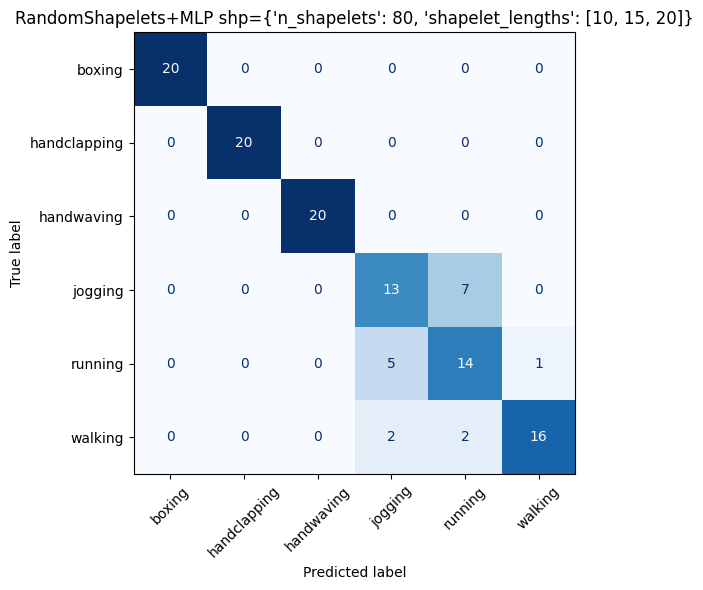

Shapelet configs: 100%|██████████| 3/3 [02:05<00:00, 41.69s/it]



PHASE 2: MLP Configuration Sweep (best shapelets: {'n_shapelets': 80, 'shapelet_lengths': [10, 15, 20]})


MLP configs:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting random shapelets: n=80, lengths=[10, 15, 20]
Transforming to shapelet distance features...


Test features: 100%|██████████| 120/120 [00:09<00:00, 12.12it/s]


Training MLP: hidden_dims=(128,), dropout=0.2, lr=0.001, epochs=30


MLP Training: 100%|██████████| 30/30 [00:01<00:00, 23.09epoch/s, loss=0.2989, train=0.866, test=0.825]


RandomShapelets+MLP mlp=(128,) drop=0.2  |  acc=0.8583  macroF1=0.8598
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.6500    0.6500    0.6500        20
     running     0.6364    0.7000    0.6667        20
     walking     0.8889    0.8000    0.8421        20

    accuracy                         0.8583       120
   macro avg     0.8625    0.8583    0.8598       120
weighted avg     0.8625    0.8583    0.8598       120

Confusion matrix saved to: outputs\figures\cm_randshapelets_mlp_mlpcfg0.png


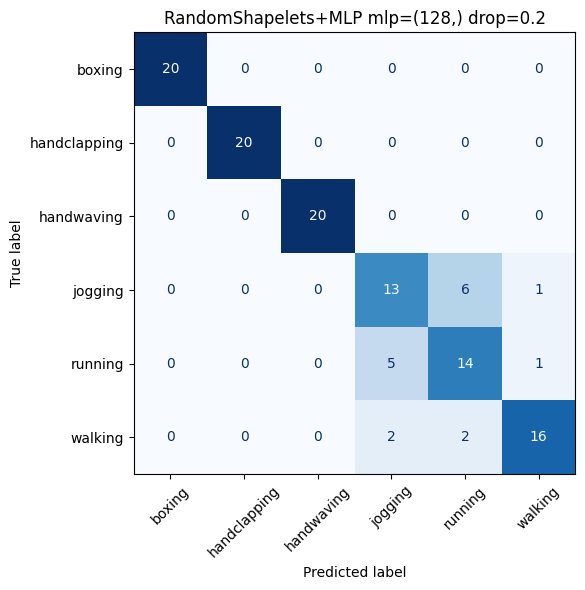

MLP configs:  33%|███▎      | 1/3 [00:51<01:43, 51.79s/it]

Extracting random shapelets: n=80, lengths=[10, 15, 20]
Transforming to shapelet distance features...


Test features: 100%|██████████| 120/120 [00:09<00:00, 12.15it/s]


Training MLP: hidden_dims=(256, 128), dropout=0.2, lr=0.001, epochs=30


MLP Training: 100%|██████████| 30/30 [00:01<00:00, 18.04epoch/s, loss=0.2716, train=0.862, test=0.842]


RandomShapelets+MLP mlp=(256, 128) drop=0.2  |  acc=0.8500  macroF1=0.8543
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.6500    0.6500    0.6500        20
     running     0.5769    0.7500    0.6522        20
     walking     1.0000    0.7000    0.8235        20

    accuracy                         0.8500       120
   macro avg     0.8712    0.8500    0.8543       120
weighted avg     0.8712    0.8500    0.8543       120

Confusion matrix saved to: outputs\figures\cm_randshapelets_mlp_mlpcfg1.png


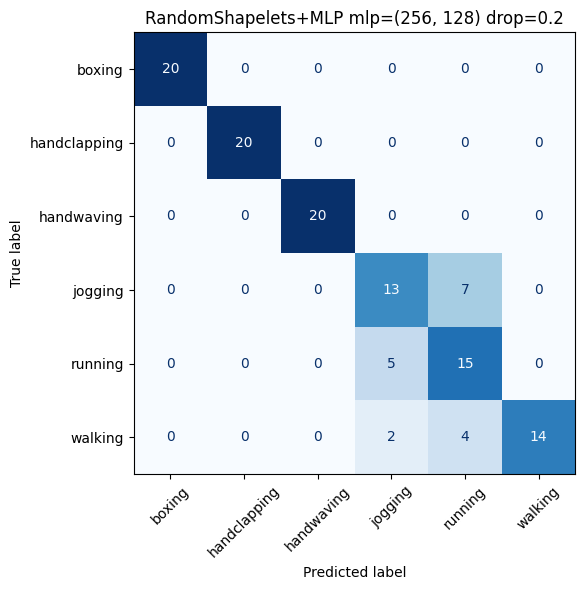

MLP configs:  67%|██████▋   | 2/3 [01:44<00:52, 52.46s/it]

Extracting random shapelets: n=80, lengths=[10, 15, 20]
Transforming to shapelet distance features...


Test features: 100%|██████████| 120/120 [00:10<00:00, 11.32it/s]


Training MLP: hidden_dims=(256, 128), dropout=0.3, lr=0.0005, epochs=40


MLP Training: 100%|██████████| 40/40 [00:02<00:00, 18.24epoch/s, loss=0.2797, train=0.871, test=0.850]


RandomShapelets+MLP mlp=(256, 128) drop=0.3  |  acc=0.8500  macroF1=0.8508
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.6500    0.6500    0.6500        20
     running     0.6190    0.6500    0.6341        20
     walking     0.8421    0.8000    0.8205        20

    accuracy                         0.8500       120
   macro avg     0.8519    0.8500    0.8508       120
weighted avg     0.8519    0.8500    0.8508       120

Confusion matrix saved to: outputs\figures\cm_randshapelets_mlp_mlpcfg2.png


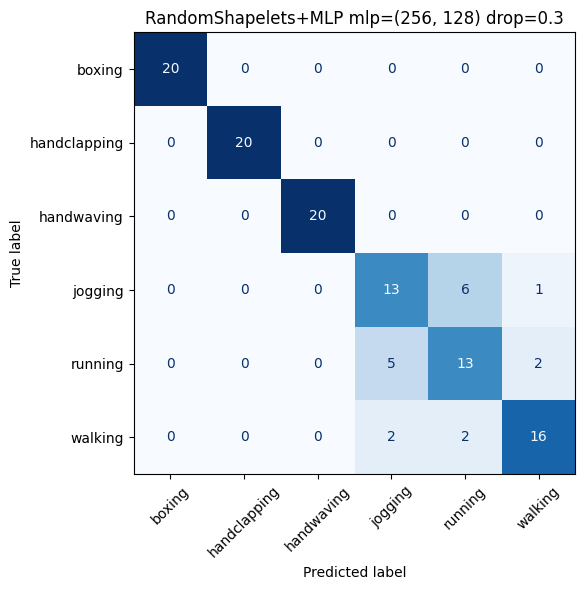

MLP configs: 100%|██████████| 3/3 [02:38<00:00, 52.68s/it]


RandomShapelets+MLP results saved to: outputs\results\results_random_shapelets_mlp_ablation.csv

Done.


In [21]:
# ==============================================================================
# CELL 11: RANDOM SHAPELETS + MLP ABLATION STUDY
# ==============================================================================
# Two-phase ablation study:
# Phase 1: Sweep random shapelet configurations with fixed MLP
# Phase 2: Sweep MLP configurations with best shapelets
# ==============================================================================

def run_random_shapelets_mlp_pipeline(train_samples, test_samples,
                                      n_shapelets=60, shapelet_lengths=[5, 10, 15, 20],
                                      hidden_dims=(256, 128), dropout=0.2, lr=1e-3, epochs=30):
    """
    Full Random Shapelets + MLP pipeline: extract shapelets, transform, train MLP, evaluate.
    """
    # Extract sequences
    X_train, y_train = get_xy(train_samples)
    X_test, y_test = get_xy(test_samples)

    # Subsample sequences for speed/consistency
    X_train_sub = [subsample_sequence(x, SHAPELET_SEQ_LEN) for x in X_train]
    X_test_sub = [subsample_sequence(x, SHAPELET_SEQ_LEN) for x in X_test]

    # Extract random shapelets
    print(f"Extracting random shapelets: n={n_shapelets}, lengths={shapelet_lengths}")
    shapelets = extract_random_shapelets(X_train_sub, n_shapelets=n_shapelets, shapelet_lengths=shapelet_lengths)

    # Transform to shapelet distance features
    print("Transforming to shapelet distance features...")
    Xtr_feat = transform_to_shapelet_features(X_train_sub, shapelets, desc="Train features")
    Xte_feat = transform_to_shapelet_features(X_test_sub, shapelets, desc="Test features")

    # Train MLP
    print(f"Training MLP: hidden_dims={hidden_dims}, dropout={dropout}, lr={lr}, epochs={epochs}")
    mlp_model, hist, y_true, y_pred = train_mlp_on_features(
        Xtr_feat, y_train, Xte_feat, y_test,
        hidden_dims=hidden_dims, lr=lr, epochs=epochs, dropout=dropout
    )

    return y_true, y_pred, hist

def run_random_shapelets_mlp_ablation(train_samples, test_samples):
    """
    Run two-phase ablation study for Random Shapelets + MLP.
    """
    # -------------------- Phase 1: Shapelet Sweep --------------------
    shapelet_configs = [
        {"n_shapelets": 40, "shapelet_lengths": [5, 10, 15]},
        {"n_shapelets": 60, "shapelet_lengths": [5, 10, 15, 20]},
        {"n_shapelets": 80, "shapelet_lengths": [10, 15, 20]},
    ]

    mlp_configs = [
        {"hidden_dims": (128,), "dropout": 0.2, "lr": 1e-3, "epochs": 30},
        {"hidden_dims": (256, 128), "dropout": 0.2, "lr": 1e-3, "epochs": 30},
        {"hidden_dims": (256, 128), "dropout": 0.3, "lr": 5e-4, "epochs": 40},
    ]

    print("=" * 60)
    print("PHASE 1: Random Shapelet Configuration Sweep")
    print("=" * 60)

    best_shapelet_config = None
    best_f1 = -1

    for i, shp_cfg in enumerate(tqdm(shapelet_configs, desc="Shapelet configs")):
        try:
            y_true, y_pred, hist = run_random_shapelets_mlp_pipeline(
                train_samples, test_samples,
                n_shapelets=shp_cfg["n_shapelets"],
                shapelet_lengths=shp_cfg["shapelet_lengths"],
                hidden_dims=(256, 128),
                dropout=0.2,
                lr=1e-3,
                epochs=30
            )

            title = f"RandomShapelets+MLP shp={shp_cfg}"
            cm_path = FIG_DIR / f"cm_randshapelets_mlp_cfg{i}.png"
            metrics = evaluate_and_report(y_true, y_pred, title=title, save_cm_path=cm_path)

            RESULTS.append({
                "method": "RandomShapelets+MLP",
                "n_shapelets": shp_cfg["n_shapelets"],
                "shapelet_lengths": str(shp_cfg["shapelet_lengths"]),
                "hidden_dims": "(256,128)",
                "dropout": 0.2,
                "lr": 1e-3,
                **metrics
            })

            if metrics["macro_f1"] > best_f1:
                best_f1 = metrics["macro_f1"]
                best_shapelet_config = shp_cfg

        except Exception as e:
            print(f"Error with shapelet config {shp_cfg}: {e}")

    # -------------------- Phase 2: MLP Sweep --------------------
    print("\n" + "=" * 60)
    print(f"PHASE 2: MLP Configuration Sweep (best shapelets: {best_shapelet_config})")
    print("=" * 60)

    if best_shapelet_config is not None:
        for j, mlp_cfg in enumerate(tqdm(mlp_configs, desc="MLP configs")):
            try:
                y_true, y_pred, hist = run_random_shapelets_mlp_pipeline(
                    train_samples, test_samples,
                    n_shapelets=best_shapelet_config["n_shapelets"],
                    shapelet_lengths=best_shapelet_config["shapelet_lengths"],
                    **mlp_cfg
                )

                title = f"RandomShapelets+MLP mlp={mlp_cfg['hidden_dims']} drop={mlp_cfg['dropout']}"
                cm_path = FIG_DIR / f"cm_randshapelets_mlp_mlpcfg{j}.png"
                metrics = evaluate_and_report(y_true, y_pred, title=title, save_cm_path=cm_path)

                RESULTS.append({
                    "method": "RandomShapelets+MLP",
                    "n_shapelets": best_shapelet_config["n_shapelets"],
                    "shapelet_lengths": str(best_shapelet_config["shapelet_lengths"]),
                    "hidden_dims": str(mlp_cfg["hidden_dims"]),
                    "dropout": mlp_cfg["dropout"],
                    "lr": mlp_cfg["lr"],
                    **metrics
                })

            except Exception as e:
                print(f"Error with MLP config {mlp_cfg}: {e}")

    # -------------------- Save Results --------------------
    df_shp = pd.DataFrame([r for r in RESULTS if r.get("method") == "RandomShapelets+MLP"])
    df_shp.to_csv(RES_DIR / "results_random_shapelets_mlp_ablation.csv", index=False)
    print(f"\nRandomShapelets+MLP results saved to: {RES_DIR / 'results_random_shapelets_mlp_ablation.csv'}")
    print("\nDone.")

# ---------------------- Run Ablation ----------------------
run_random_shapelets_mlp_ablation(train_samples, test_samples)


# METHOD 3 — LSTM classifier (required)

**Owners:** Person B (primary), Person A (review)

### Method Description:
**Long Short-Term Memory (LSTM)** networks are recurrent neural networks designed to learn long-term dependencies in sequential data. They use gating mechanisms to selectively remember or forget information over time.

### Key Components:
1. **Variable-length handling:** Uses `pack_padded_sequence` for efficient processing
2. **Bidirectional LSTM:** Processes sequence in both directions for better context
3. **Classification head:** Final hidden state → fully connected → class logits

### Completed Tasks:
- [X] Implement PyTorch Dataset with variable-length sequences
- [X] Implement padded collate function with length tracking
- [X] Implement bidirectional LSTM classifier
- [X] Ablation: hidden size, layers, bidirectional, dropout

RUNNING LSTM BASELINE (hidden=128, layers=2, bidirectional=True)


LSTM Training: 100%|██████████| 25/25 [02:41<00:00,  6.44s/epoch, loss=0.3367, train_acc=0.8497, test_acc=0.8000]


LSTM  |  acc=0.8000  macroF1=0.7975
              precision    recall  f1-score   support

      boxing     1.0000    0.9500    0.9744        20
handclapping     0.9524    1.0000    0.9756        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.5000    0.3500    0.4118        20
     running     0.5172    0.7500    0.6122        20
     walking     0.8824    0.7500    0.8108        20

    accuracy                         0.8000       120
   macro avg     0.8087    0.8000    0.7975       120
weighted avg     0.8087    0.8000    0.7975       120

Confusion matrix saved to: outputs\figures\cm_lstm.png


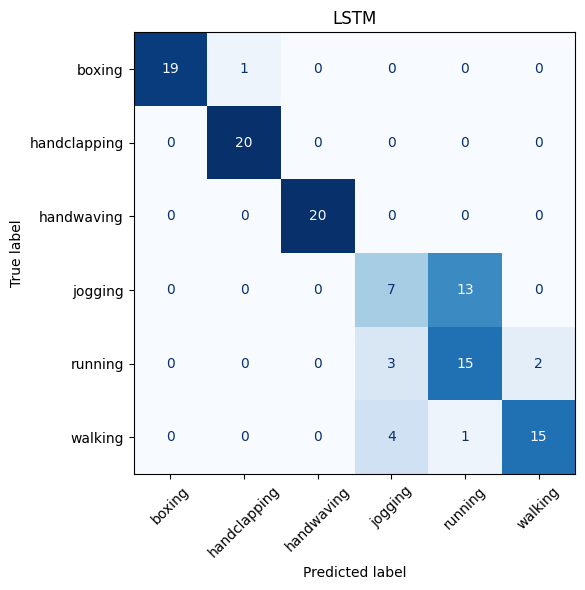

In [16]:
# ==============================================================================
# CELL 12: LSTM CLASSIFIER
# ==============================================================================
# Long Short-Term Memory (LSTM) network for sequence classification.
#
# LSTM is a recurrent neural network that can learn long-term dependencies
# using gating mechanisms (input, forget, output gates). Bidirectional LSTMs
# process the sequence in both forward and backward directions.
#
# Key features:
# - Variable-length sequence handling with pack_padded_sequence
# - Bidirectional processing for better temporal context
# - Final hidden state used for classification
# ==============================================================================

class PoseSeqDataset(Dataset):
    """
    PyTorch Dataset for pose sequences.
    
    Handles both variable-length and fixed-length sequences.
    
    Args:
        sample_list: List of sample dictionaries with 'X', 'y', 'length' keys
        pad_to_maxlen: If True, pad/truncate sequences to T_max
        T_max: Target sequence length for padding
    """
    def __init__(self, sample_list, pad_to_maxlen=False, T_max=T_MAX):
        self.samples = sample_list
        self.pad_to_maxlen = pad_to_maxlen
        self.T_max = T_max
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        s = self.samples[idx]
        X = s["X"]
        y = s["y"]
        
        if self.pad_to_maxlen:
            X = pad_or_truncate(X, self.T_max)
            length = min(s["length"], self.T_max)
        else:
            length = s["length"]
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long), length

def collate_pad(batch):
    """
    Custom collate function for variable-length sequences.
    
    Pads sequences to the maximum length in the batch and tracks
    original lengths for use with pack_padded_sequence.
    
    Args:
        batch: List of (X, y, length) tuples
        
    Returns:
        Tuple of (X_padded, lengths, y):
        - X_padded: [B, T_max, D] tensor
        - lengths: [B] tensor of original lengths
        - y: [B] tensor of labels
    """
    xs, ys, lens = zip(*batch)
    lens = torch.tensor(lens, dtype=torch.long)
    xs_padded = pad_sequence(xs, batch_first=True)  # [B, T_max, D]
    ys = torch.stack(ys)
    return xs_padded, lens, ys

class LSTMClassifier(nn.Module):
    """
    Bidirectional LSTM for sequence classification.
    
    Uses the final hidden state from the LSTM for classification.
    Supports both unidirectional and bidirectional modes.
    
    Args:
        input_dim: Feature dimension per timestep
        hidden_size: LSTM hidden state size
        num_layers: Number of stacked LSTM layers
        num_classes: Number of output classes
        bidirectional: If True, use bidirectional LSTM
        dropout: Dropout between LSTM layers (only if num_layers > 1)
    """
    def __init__(self, input_dim, hidden_size, num_layers, num_classes, bidirectional=False, dropout=0.2):
        super().__init__()
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_dim, hidden_size, num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        # Output dimension depends on bidirectional mode
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, num_classes)
    
    def forward(self, x, lengths):
        """
        Forward pass with packed sequences for efficiency.
        
        Args:
            x: Padded sequences [B, T, D]
            lengths: Original sequence lengths [B]
            
        Returns:
            Logits [B, num_classes]
        """
        # Sort by length (required for pack_padded_sequence)
        lengths_sorted, idx_sort = torch.sort(lengths, descending=True)
        x_sorted = x[idx_sort]
        
        # Pack sequences for efficient LSTM processing
        packed = pack_padded_sequence(x_sorted, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, (hn, cn) = self.lstm(packed)
        
        # Extract final hidden state
        if self.bidirectional:
            # hn shape: [num_layers*2, B, hidden_size]
            # Take last layer's forward and backward hidden states
            forward_last = hn[-2]
            backward_last = hn[-1]
            h_last = torch.cat([forward_last, backward_last], dim=1)
        else:
            h_last = hn[-1]  # [B, hidden_size]
        
        # Unsort to match original batch order
        _, idx_unsort = torch.sort(idx_sort)
        h_last = h_last[idx_unsort]
        
        # Classify
        logits = self.fc(h_last)
        return logits

def train_lstm(train_samples, test_samples, hidden_size=128, num_layers=2, 
               bidirectional=True, dropout=0.2, lr=1e-3, epochs=25, batch_size=32):
    """
    Train LSTM classifier on pose sequences.
    
    Args:
        train_samples: Training sample list
        test_samples: Test sample list
        hidden_size: LSTM hidden dimension
        num_layers: Number of stacked LSTM layers
        bidirectional: Use bidirectional LSTM
        dropout: Dropout rate
        lr: Learning rate
        epochs: Number of training epochs
        batch_size: Batch size
        
    Returns:
        Tuple of (model, history, y_true, y_pred)
    """
    # Create datasets (variable-length, not padded)
    train_ds = PoseSeqDataset(train_samples, pad_to_maxlen=False)
    test_ds = PoseSeqDataset(test_samples, pad_to_maxlen=False)
    
    # Create data loaders with custom collate
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pad)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)
    
    # Initialize model
    input_dim = train_samples[0]["X"].shape[1]
    model = LSTMClassifier(
        input_dim, hidden_size, num_layers, len(CLASS_NAMES),
        bidirectional=bidirectional, dropout=dropout
    ).to(DEVICE)
    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    history = {"train_loss": [], "train_acc": [], "test_acc": []}
    
    # Training loop
    epoch_pbar = tqdm(range(1, epochs + 1), desc="LSTM Training", unit="epoch")
    for ep in epoch_pbar:
        # Training phase
        model.train()
        total_loss = 0.0
        correct = 0
        n = 0
        
        for xb, lens, yb in train_loader:
            xb, lens, yb = xb.to(DEVICE), lens.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb, lens)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            
            total_loss += loss.item() * len(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            n += len(xb)
        
        train_loss = total_loss / n
        train_acc = correct / n
        
        # Evaluation phase
        model.eval()
        all_pred = []
        all_true = []
        with torch.no_grad():
            for xb, lens, yb in test_loader:
                xb, lens = xb.to(DEVICE), lens.to(DEVICE)
                logits = model(xb, lens)
                pred = logits.argmax(dim=1).cpu().numpy()
                all_pred.append(pred)
                all_true.append(yb.numpy())
        
        all_pred = np.concatenate(all_pred)
        all_true = np.concatenate(all_true)
        test_acc = accuracy_score(all_true, all_pred)
        
        epoch_pbar.set_postfix({
            "loss": f"{train_loss:.4f}",
            "train_acc": f"{train_acc:.4f}",
            "test_acc": f"{test_acc:.4f}"
        })
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
    
    return model, history, all_true, all_pred

# ---------------------- Run LSTM Baseline ----------------------
print("=" * 60)
print("RUNNING LSTM BASELINE (hidden=128, layers=2, bidirectional=True)")
print("=" * 60)

lstm_model, lstm_hist, y_true, y_pred = train_lstm(train_samples, test_samples)
metrics = evaluate_and_report(y_true, y_pred, title="LSTM", save_cm_path=FIG_DIR/"cm_lstm.png")
RESULTS.append({
    "method": "LSTM",
    "hidden_size": 128,
    "num_layers": 2,
    "bidirectional": True,
    "dropout": 0.2,
    **metrics
})

## METHOD 3 — Ablation grid (LSTM)

**Owners:** Person B

### Ablation Design:
- **hidden_size:** [64, 128, 256] - LSTM hidden dimension
- **num_layers:** [1, 2, 3] - Depth of stacked LSTMs
- **bidirectional:** [False, True] - Unidirectional vs bidirectional
- **dropout:** [0.0, 0.2, 0.5] - Regularization strength

### Expected Insights:
- Larger hidden_size → More capacity, risk of overfitting
- More layers → Better feature hierarchy, harder to train
- Bidirectional → Better for classification, 2x parameters

Running 5 LSTM configurations (optimized for speed)...
[1/5] h=64, L=2, bi=True, drop=0.2


LSTM Training: 100%|██████████| 10/10 [00:35<00:00,  3.54s/epoch, loss=0.6208, train_acc=0.7328, test_acc=0.7833]


LSTM h=64 L=2 bi=True drop=0.2  |  acc=0.7833  macroF1=0.7806
              precision    recall  f1-score   support

      boxing     0.9524    1.0000    0.9756        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.5556    0.5000    0.5263        20
     running     0.4500    0.4500    0.4500        20
     walking     0.7143    0.7500    0.7317        20

    accuracy                         0.7833       120
   macro avg     0.7787    0.7833    0.7806       120
weighted avg     0.7787    0.7833    0.7806       120

Confusion matrix saved to: outputs\figures\cm_lstm_h64_L2_biTrue_d0.2.png


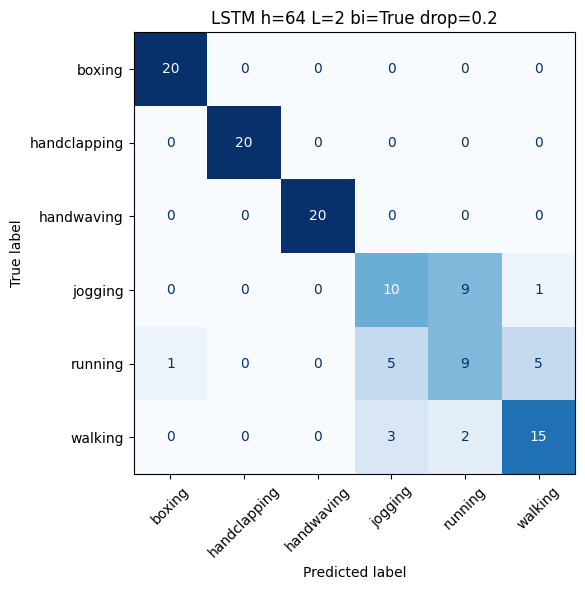

[2/5] h=256, L=2, bi=True, drop=0.2


LSTM Training: 100%|██████████| 10/10 [00:41<00:00,  4.19s/epoch, loss=0.5559, train_acc=0.7662, test_acc=0.8000]


LSTM h=256 L=2 bi=True drop=0.2  |  acc=0.8000  macroF1=0.7993
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     0.9048    0.9500    0.9268        20
  handwaving     0.9474    0.9000    0.9231        20
     jogging     0.6429    0.4500    0.5294        20
     running     0.5185    0.7000    0.5957        20
     walking     0.8421    0.8000    0.8205        20

    accuracy                         0.8000       120
   macro avg     0.8093    0.8000    0.7993       120
weighted avg     0.8093    0.8000    0.7993       120

Confusion matrix saved to: outputs\figures\cm_lstm_h256_L2_biTrue_d0.2.png


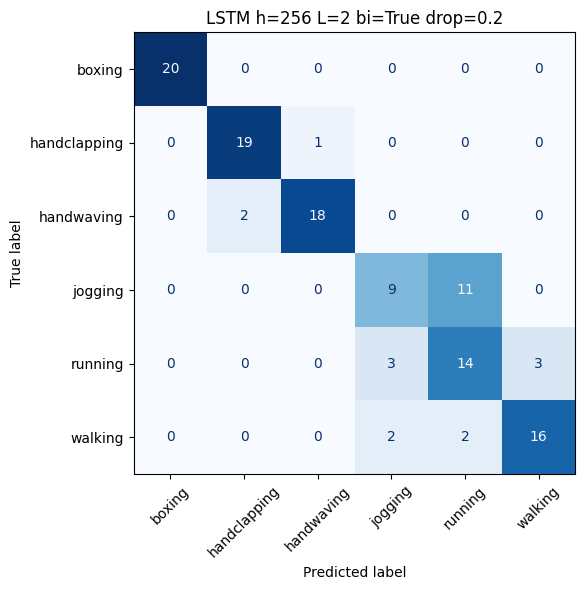

[3/5] h=128, L=1, bi=True, drop=0.2


LSTM Training: 100%|██████████| 10/10 [00:21<00:00,  2.16s/epoch, loss=0.8536, train_acc=0.5992, test_acc=0.6500]


LSTM h=128 L=1 bi=True drop=0.2  |  acc=0.6500  macroF1=0.6201
              precision    recall  f1-score   support

      boxing     1.0000    0.9500    0.9744        20
handclapping     0.8235    0.7000    0.7568        20
  handwaving     0.7727    0.8500    0.8095        20
     jogging     0.4194    0.6500    0.5098        20
     running     0.3333    0.0500    0.0870        20
     walking     0.5000    0.7000    0.5833        20

    accuracy                         0.6500       120
   macro avg     0.6415    0.6500    0.6201       120
weighted avg     0.6415    0.6500    0.6201       120

Confusion matrix saved to: outputs\figures\cm_lstm_h128_L1_biTrue_d0.2.png


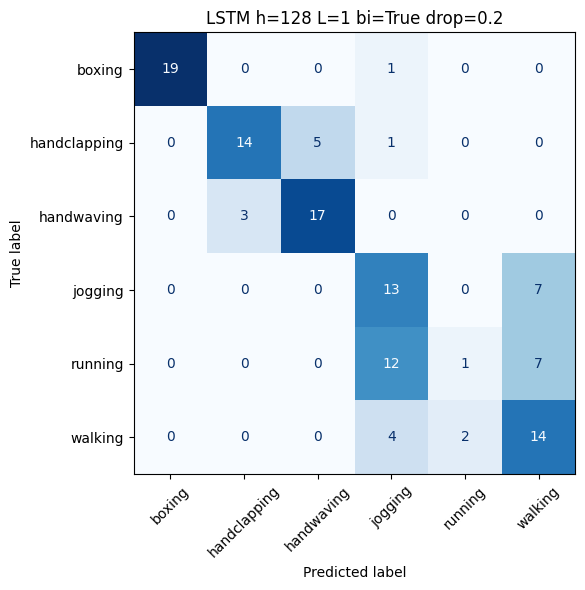

[4/5] h=128, L=2, bi=False, drop=0.2


LSTM Training: 100%|██████████| 10/10 [00:20<00:00,  2.10s/epoch, loss=0.9849, train_acc=0.5574, test_acc=0.6417]


LSTM h=128 L=2 bi=False drop=0.2  |  acc=0.6417  macroF1=0.6073
              precision    recall  f1-score   support

      boxing     0.8696    1.0000    0.9302        20
handclapping     0.8000    0.2000    0.3200        20
  handwaving     0.5758    0.9500    0.7170        20
     jogging     0.6471    0.5500    0.5946        20
     running     0.7000    0.3500    0.4667        20
     walking     0.5000    0.8000    0.6154        20

    accuracy                         0.6417       120
   macro avg     0.6821    0.6417    0.6073       120
weighted avg     0.6821    0.6417    0.6073       120

Confusion matrix saved to: outputs\figures\cm_lstm_h128_L2_biFalse_d0.2.png


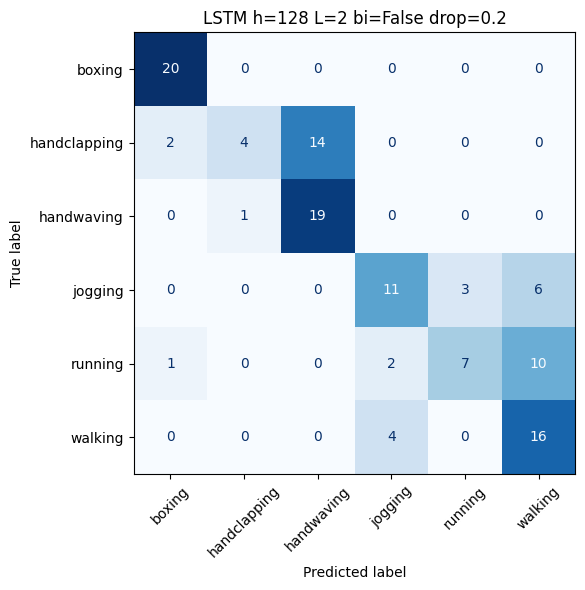

[5/5] h=128, L=2, bi=True, drop=0.0


LSTM Training: 100%|██████████| 10/10 [00:39<00:00,  3.94s/epoch, loss=0.5378, train_acc=0.7641, test_acc=0.8000]


LSTM h=128 L=2 bi=True drop=0.0  |  acc=0.8000  macroF1=0.7885
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     0.9524    1.0000    0.9756        20
  handwaving     1.0000    0.9500    0.9744        20
     jogging     0.5517    0.8000    0.6531        20
     running     0.6667    0.3000    0.4138        20
     walking     0.6818    0.7500    0.7143        20

    accuracy                         0.8000       120
   macro avg     0.8088    0.8000    0.7885       120
weighted avg     0.8088    0.8000    0.7885       120

Confusion matrix saved to: outputs\figures\cm_lstm_h128_L2_biTrue_d0.0.png


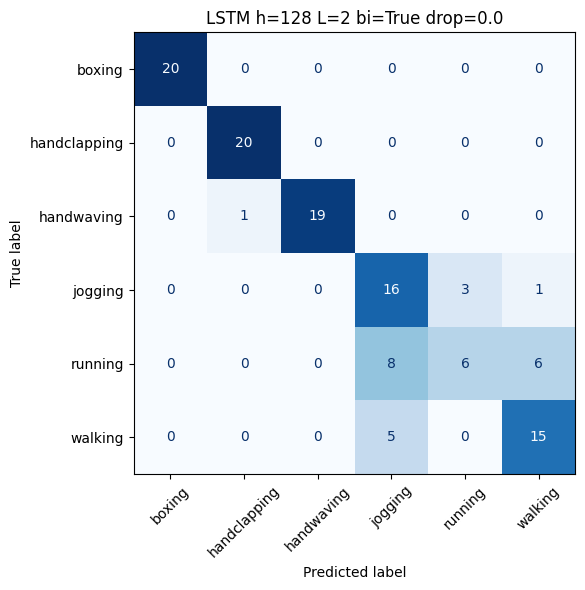

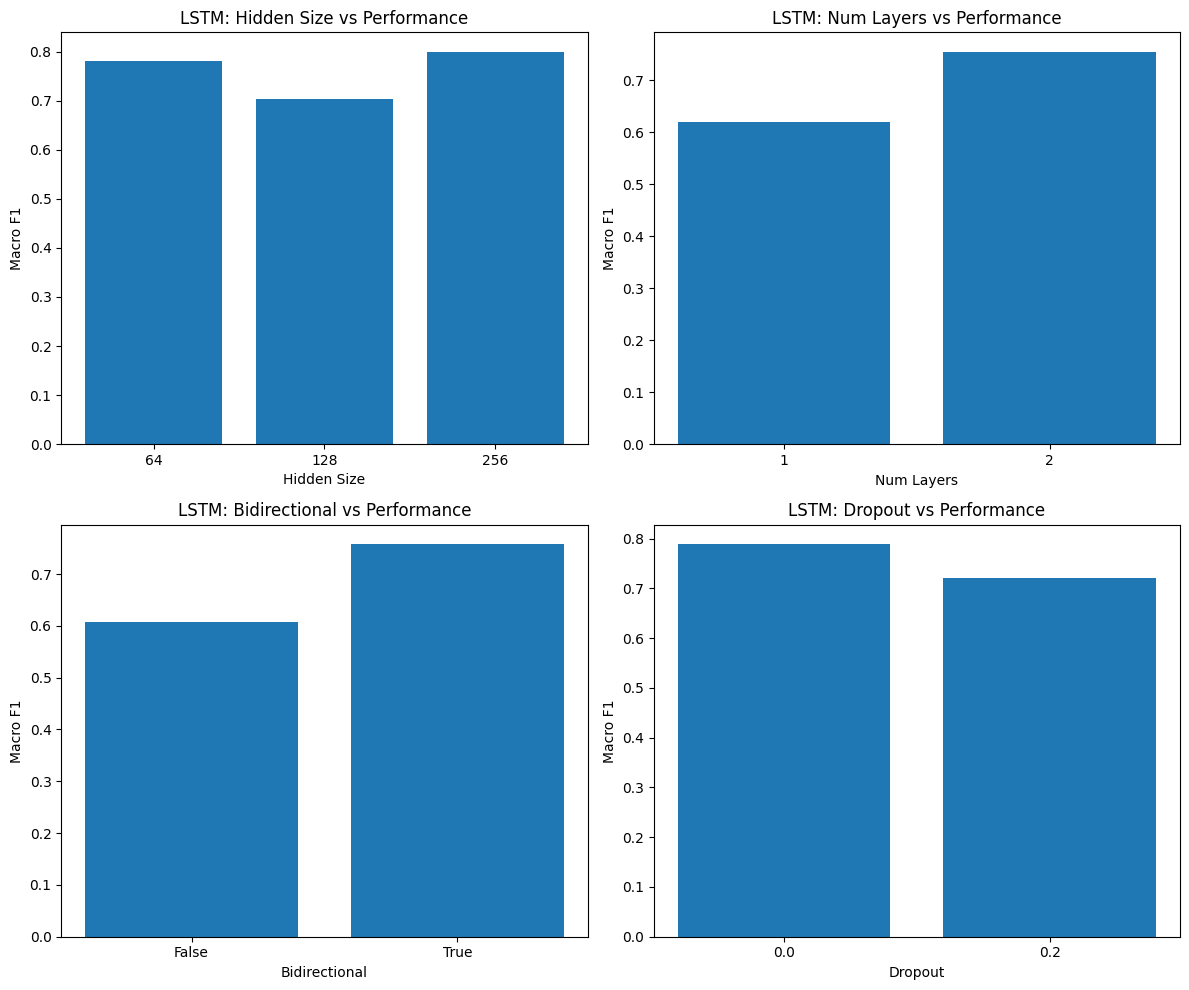

In [17]:
# LSTM ABLATION STUDY - Optimized for faster runtime
def run_lstm_ablation(train_samples, test_samples):
    # Reduced config set - still covers all ablation dimensions from assignment
    configs = [
        # Hidden size ablation (3 values instead of full range)
        {"hidden_size": 64, "num_layers": 2, "bidirectional": True, "dropout": 0.2},
        {"hidden_size": 128, "num_layers": 2, "bidirectional": True, "dropout": 0.2},  # baseline
        {"hidden_size": 256, "num_layers": 2, "bidirectional": True, "dropout": 0.2},
        
        # Num layers ablation (2 values: shallow vs deep)
        {"hidden_size": 128, "num_layers": 1, "bidirectional": True, "dropout": 0.2},
        
        # Bidirectional ablation
        {"hidden_size": 128, "num_layers": 2, "bidirectional": False, "dropout": 0.2},
        
        # Dropout ablation (2 values: no dropout vs with dropout)
        {"hidden_size": 128, "num_layers": 2, "bidirectional": True, "dropout": 0.0},
    ]
    
    existing = {(r.get("method"), r.get("hidden_size"), r.get("num_layers"),
                 r.get("bidirectional"), r.get("dropout"))
                for r in RESULTS if r.get("method") == "LSTM"}
    
    configs_to_run = [cfg for cfg in configs if ("LSTM", cfg["hidden_size"], 
                      cfg["num_layers"], cfg["bidirectional"], cfg["dropout"]) not in existing]
    
    print(f"Running {len(configs_to_run)} LSTM configurations (optimized for speed)...")
    
    for idx, cfg in enumerate(configs_to_run):
        print(f"[{idx+1}/{len(configs_to_run)}] h={cfg['hidden_size']}, L={cfg['num_layers']}, "
              f"bi={cfg['bidirectional']}, drop={cfg['dropout']}")
        
        try:
            # Reduced epochs (10 instead of 15) and larger batch size (64) for faster training
            model, hist, y_true, y_pred = train_lstm(train_samples, test_samples, **cfg, 
                                                      lr=1e-3, epochs=10, batch_size=64)
            
            title = f"LSTM h={cfg['hidden_size']} L={cfg['num_layers']} bi={cfg['bidirectional']} drop={cfg['dropout']}"
            cm_path = FIG_DIR / f"cm_lstm_h{cfg['hidden_size']}_L{cfg['num_layers']}_bi{cfg['bidirectional']}_d{cfg['dropout']}.png"
            
            metrics = evaluate_and_report(y_true, y_pred, title=title, save_cm_path=cm_path)
            RESULTS.append({"method": "LSTM", **cfg, **metrics})
        except Exception as e:
            print(f"Error: {e}")
    
    # Save and plot
    df_lstm = pd.DataFrame([r for r in RESULTS if r.get("method") == "LSTM"])
    df_lstm.to_csv(RES_DIR / "results_lstm_ablation.csv", index=False)
    
    if len(df_lstm) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        for ax, col, title in zip(axes.flat, 
                                   ["hidden_size", "num_layers", "bidirectional", "dropout"],
                                   ["Hidden Size", "Num Layers", "Bidirectional", "Dropout"]):
            perf = df_lstm.groupby(col)["macro_f1"].mean().reset_index()
            ax.bar(perf[col].astype(str), perf["macro_f1"])
            ax.set_xlabel(title)
            ax.set_ylabel("Macro F1")
            ax.set_title(f"LSTM: {title} vs Performance")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "lstm_ablation_summary.png", dpi=200)
        plt.show()

run_lstm_ablation(train_samples, test_samples)

# METHOD 4 — Temporal 1D CNN (extra method - required)

**Owners:** Person A (primary), Person B (review)

### Method Description:
**Temporal 1D Convolutional Neural Networks** apply convolution operations along the time dimension of sequences. They can capture local temporal patterns efficiently with hierarchical feature learning.

### Key Components:
1. **1D Convolutions:** Learn local temporal patterns with configurable kernel sizes
2. **MaxPooling:** Reduce temporal resolution and increase receptive field
3. **Global Average Pooling:** Aggregate across entire sequence for fixed-size representation
4. **Classification head:** Fully connected layer to class logits

### Completed Tasks:
- [X] Implement TemporalCNN with configurable architecture
- [X] Fixed-length input handling (pad/truncate to T_MAX)
- [X] Ablation: kernel sizes, channel depths, dropout

RUNNING TEMPORAL CNN BASELINE (channels=(128,128), kernel=5)


TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  6.28epoch/s, loss=0.2512, train_acc=0.8935, test_acc=0.8333]


TemporalCNN  |  acc=0.8333  macroF1=0.8276
              precision    recall  f1-score   support

      boxing     0.9524    1.0000    0.9756        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.5000    0.8500    0.6296        20
     running     1.0000    0.3500    0.5185        20
     walking     0.8889    0.8000    0.8421        20

    accuracy                         0.8333       120
   macro avg     0.8902    0.8333    0.8276       120
weighted avg     0.8902    0.8333    0.8276       120

Confusion matrix saved to: outputs\figures\cm_temporalcnn.png


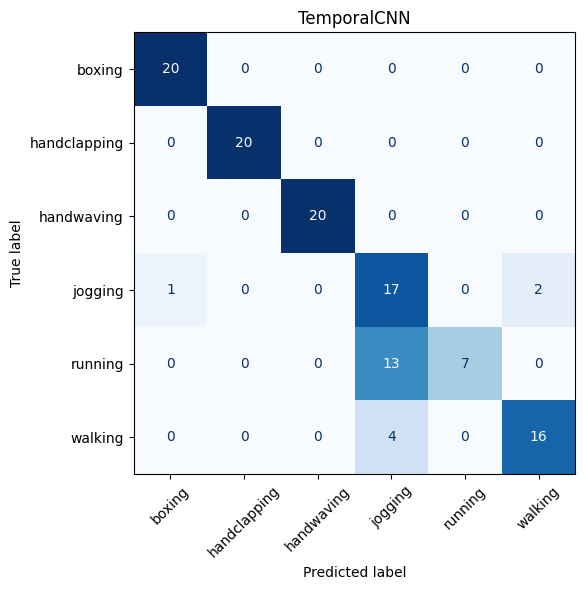

In [18]:
# ==============================================================================
# CELL 14: TEMPORAL 1D CNN CLASSIFIER
# ==============================================================================
# Temporal 1D Convolutional Neural Network for sequence classification.
#
# 1D CNNs process sequences by applying convolutions along the time dimension.
# They excel at capturing local temporal patterns and are more efficient than
# RNNs for some tasks.
#
# Architecture:
# - Stack of Conv1d + ReLU + Dropout + MaxPool blocks
# - Global Average Pooling to aggregate temporal features
# - Fully connected output layer
# ==============================================================================

class TemporalCNN(nn.Module):
    """
    Temporal 1D CNN for sequence classification.
    
    Applies 1D convolutions along the time dimension to extract local
    temporal features, followed by global pooling and classification.
    
    Args:
        input_dim: Number of features per timestep
        num_classes: Number of output classes
        channels: Tuple of channel sizes for each conv layer, e.g., (128, 128)
        kernel_size: Size of convolutional kernels
        dropout: Dropout probability for regularization
    """
    def __init__(self, input_dim, num_classes, channels=(128, 128), kernel_size=5, dropout=0.2):
        super().__init__()
        
        layers = []
        in_ch = input_dim
        
        # Build convolutional blocks
        for ch in channels:
            layers += [
                nn.Conv1d(in_ch, ch, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.MaxPool1d(kernel_size=2),  # Halve temporal resolution
            ]
            in_ch = ch
        
        self.conv = nn.Sequential(*layers)
        
        # Classification head with global average pooling
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # Global average pool over time
            nn.Flatten(),
            nn.Linear(in_ch, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor [B, T, D] (batch, time, features)
            
        Returns:
            Logits [B, num_classes]
        """
        # Transpose: [B, T, D] -> [B, D, T] (Conv1d expects channel-first)
        x = x.transpose(1, 2)
        z = self.conv(x)
        return self.head(z)

def train_temporal_cnn(train_samples, test_samples, channels=(128, 128), kernel_size=5,
                       dropout=0.2, lr=1e-3, epochs=25, batch_size=32):
    """
    Train Temporal CNN classifier on pose sequences.
    
    Uses fixed-length sequences (padded/truncated to T_MAX).
    
    Args:
        train_samples: Training sample list
        test_samples: Test sample list
        channels: Tuple of channel sizes per conv layer
        kernel_size: Convolution kernel size
        dropout: Dropout probability
        lr: Learning rate
        epochs: Training epochs
        batch_size: Batch size
        
    Returns:
        Tuple of (model, history, y_true, y_pred)
    """
    # Create datasets with fixed-length padding
    train_ds = PoseSeqDataset(train_samples, pad_to_maxlen=True, T_max=T_MAX)
    test_ds = PoseSeqDataset(test_samples, pad_to_maxlen=True, T_max=T_MAX)
    
    def collate_fixed(batch):
        """Collate function for fixed-length sequences."""
        xs, ys, lens = zip(*batch)
        xs = torch.stack(xs)  # Already fixed length [T_MAX, D]
        ys = torch.stack(ys)
        return xs, ys
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fixed)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fixed)
    
    # Initialize model
    input_dim = train_samples[0]["X"].shape[1]
    model = TemporalCNN(input_dim, len(CLASS_NAMES), channels=channels, 
                        kernel_size=kernel_size, dropout=dropout).to(DEVICE)
    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    history = {"train_loss": [], "train_acc": [], "test_acc": []}
    
    # Training loop
    epoch_pbar = tqdm(range(1, epochs + 1), desc="TemporalCNN Training", unit="epoch")
    for ep in epoch_pbar:
        # Training phase
        model.train()
        total_loss = 0.0
        correct = 0
        n = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            
            total_loss += loss.item() * len(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            n += len(xb)
        
        train_loss = total_loss / n
        train_acc = correct / n
        
        # Evaluation phase
        model.eval()
        all_pred = []
        all_true = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                logits = model(xb)
                pred = logits.argmax(dim=1).cpu().numpy()
                all_pred.append(pred)
                all_true.append(yb.numpy())
        
        all_pred = np.concatenate(all_pred)
        all_true = np.concatenate(all_true)
        test_acc = accuracy_score(all_true, all_pred)
        
        epoch_pbar.set_postfix({
            "loss": f"{train_loss:.4f}",
            "train_acc": f"{train_acc:.4f}",
            "test_acc": f"{test_acc:.4f}"
        })
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
    
    return model, history, all_true, all_pred

# ---------------------- Run TemporalCNN Baseline ----------------------
print("=" * 60)
print("RUNNING TEMPORAL CNN BASELINE (channels=(128,128), kernel=5)")
print("=" * 60)

cnn_model, cnn_hist, y_true, y_pred = train_temporal_cnn(train_samples, test_samples)
metrics = evaluate_and_report(y_true, y_pred, title="TemporalCNN", save_cm_path=FIG_DIR/"cm_temporalcnn.png")
RESULTS.append({
    "method": "TemporalCNN",
    "channels": (128, 128),
    "kernel_size": 5,
    "dropout": 0.2,
    **metrics
})

## METHOD 4 — Ablation grid (Temporal CNN)

**Owners:** Person A

### Ablation Design:
- **kernel_size:** [3, 5, 7] - Size of temporal receptive field
- **channels:** [(64,64), (128,128), (256,256), (128,128,128)] - Network width/depth
- **dropout:** [0.0, 0.2, 0.5] - Regularization strength

### Expected Insights:
- Larger kernels → Capture longer-range patterns, more parameters
- More/wider channels → More capacity, risk of overfitting
- Higher dropout → Better generalization on small datasets

Running 7 TemporalCNN configurations...
(Skipping 1 already completed)


TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  7.63epoch/s, loss=0.2725, train_acc=0.8789, test_acc=0.8333]


TemporalCNN ch=(128, 128) k=3 drop=0.2  |  acc=0.8333  macroF1=0.8147
              precision    recall  f1-score   support

      boxing     0.9524    1.0000    0.9756        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6250    0.2500    0.3571        20
     running     0.5882    1.0000    0.7407        20
     walking     0.9412    0.8000    0.8649        20

    accuracy                         0.8333       120
   macro avg     0.8432    0.8333    0.8147       120
weighted avg     0.8432    0.8333    0.8147       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch128_128_k3_d0.2.png


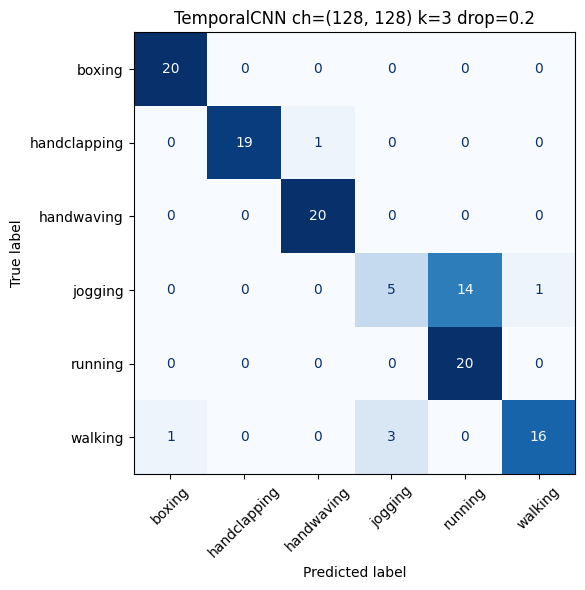

TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  7.56epoch/s, loss=0.2129, train_acc=0.8894, test_acc=0.8667]


TemporalCNN ch=(128, 128) k=7 drop=0.2  |  acc=0.8667  macroF1=0.8660
              precision    recall  f1-score   support

      boxing     0.8696    1.0000    0.9302        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6296    0.8500    0.7234        20
     running     0.9231    0.6000    0.7273        20
     walking     0.9412    0.8000    0.8649        20

    accuracy                         0.8667       120
   macro avg     0.8860    0.8667    0.8660       120
weighted avg     0.8860    0.8667    0.8660       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch128_128_k7_d0.2.png


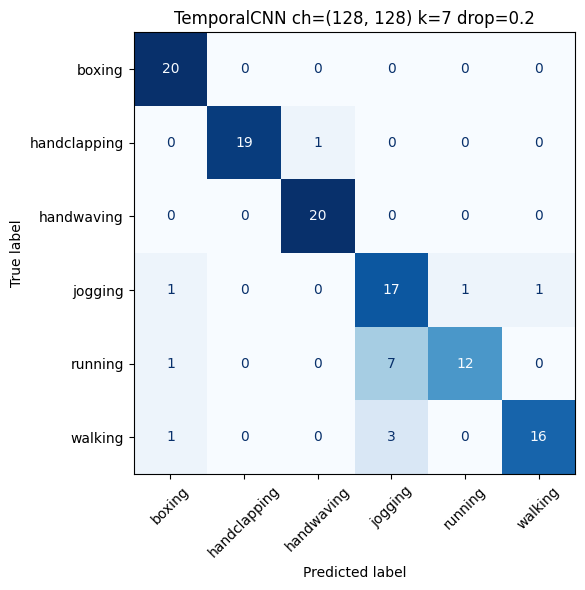

TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  7.35epoch/s, loss=0.2716, train_acc=0.8685, test_acc=0.8833]


TemporalCNN ch=(64, 64) k=5 drop=0.2  |  acc=0.8833  macroF1=0.8838
              precision    recall  f1-score   support

      boxing     0.8696    1.0000    0.9302        20
handclapping     1.0000    1.0000    1.0000        20
  handwaving     1.0000    1.0000    1.0000        20
     jogging     0.6818    0.7500    0.7143        20
     running     0.7895    0.7500    0.7692        20
     walking     1.0000    0.8000    0.8889        20

    accuracy                         0.8833       120
   macro avg     0.8901    0.8833    0.8838       120
weighted avg     0.8901    0.8833    0.8838       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch64_64_k5_d0.2.png


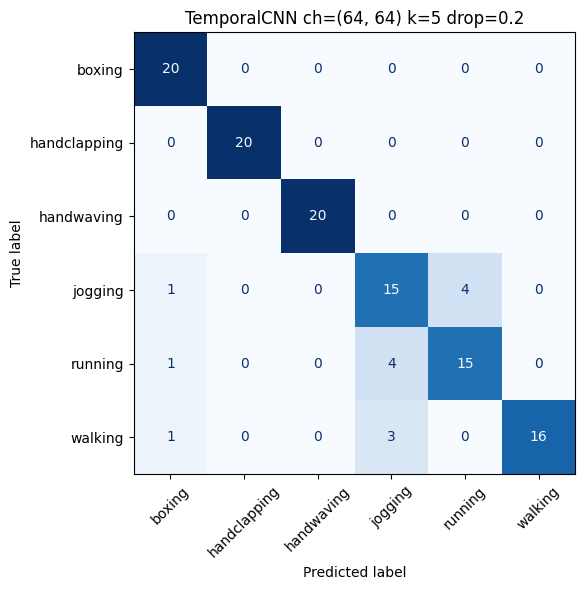

TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  7.64epoch/s, loss=0.1988, train_acc=0.9186, test_acc=0.8667]


TemporalCNN ch=(256, 256) k=5 drop=0.2  |  acc=0.8667  macroF1=0.8697
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6000    0.7500    0.6667        20
     running     0.7778    0.7000    0.7368        20
     walking     0.9412    0.8000    0.8649        20

    accuracy                         0.8667       120
   macro avg     0.8786    0.8667    0.8697       120
weighted avg     0.8786    0.8667    0.8697       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch256_256_k5_d0.2.png


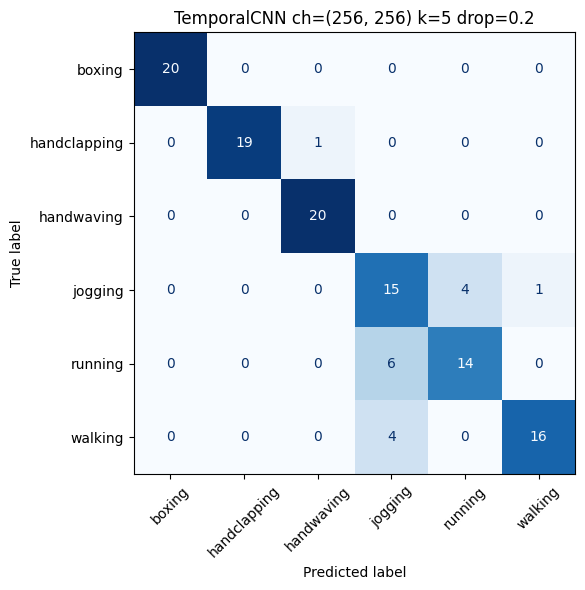

TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  6.72epoch/s, loss=0.2235, train_acc=0.8914, test_acc=0.8667]


TemporalCNN ch=(128, 128, 128) k=5 drop=0.2  |  acc=0.8667  macroF1=0.8674
              precision    recall  f1-score   support

      boxing     0.9091    1.0000    0.9524        20
handclapping     0.9091    1.0000    0.9524        20
  handwaving     1.0000    0.9000    0.9474        20
     jogging     0.6667    0.7000    0.6829        20
     running     0.7619    0.8000    0.7805        20
     walking     1.0000    0.8000    0.8889        20

    accuracy                         0.8667       120
   macro avg     0.8745    0.8667    0.8674       120
weighted avg     0.8745    0.8667    0.8674       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch128_128_128_k5_d0.2.png


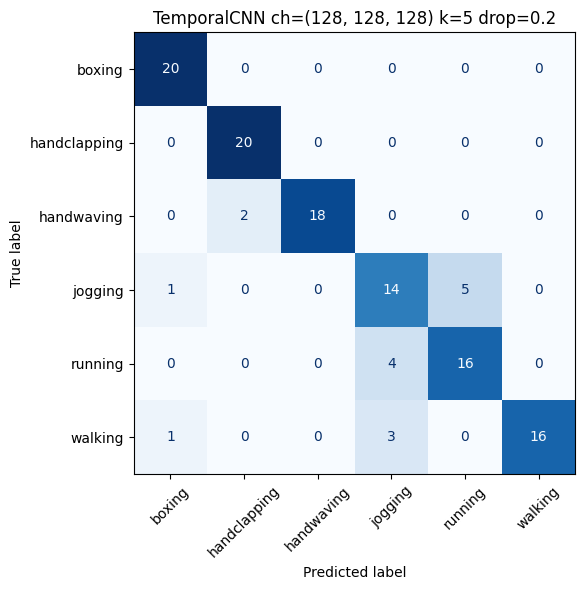

TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  7.05epoch/s, loss=0.2502, train_acc=0.8873, test_acc=0.8583]


TemporalCNN ch=(128, 128) k=5 drop=0.0  |  acc=0.8583  macroF1=0.8582
              precision    recall  f1-score   support

      boxing     0.8696    1.0000    0.9302        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.6250    0.7500    0.6818        20
     running     0.8125    0.6500    0.7222        20
     walking     0.9412    0.8000    0.8649        20

    accuracy                         0.8583       120
   macro avg     0.8668    0.8583    0.8582       120
weighted avg     0.8668    0.8583    0.8582       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch128_128_k5_d0.0.png


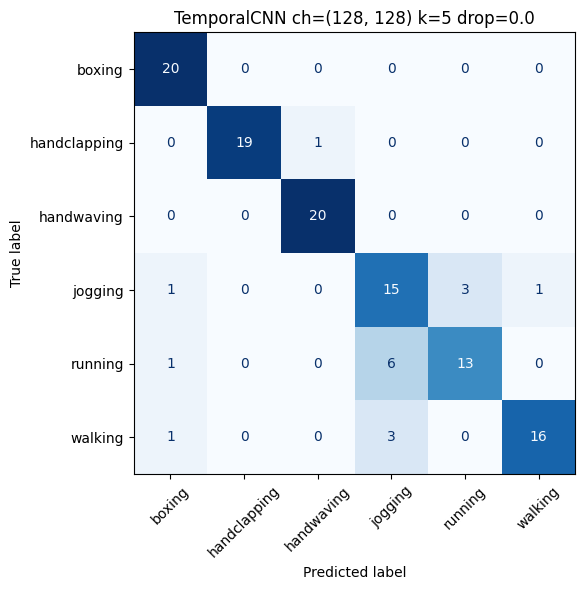

TemporalCNN Training: 100%|██████████| 25/25 [00:03<00:00,  6.76epoch/s, loss=0.2509, train_acc=0.8935, test_acc=0.8583]


TemporalCNN ch=(128, 128) k=5 drop=0.5  |  acc=0.8583  macroF1=0.8609
              precision    recall  f1-score   support

      boxing     1.0000    1.0000    1.0000        20
handclapping     1.0000    0.9500    0.9744        20
  handwaving     0.9524    1.0000    0.9756        20
     jogging     0.5909    0.6500    0.6190        20
     running     0.7143    0.7500    0.7317        20
     walking     0.9412    0.8000    0.8649        20

    accuracy                         0.8583       120
   macro avg     0.8665    0.8583    0.8609       120
weighted avg     0.8665    0.8583    0.8609       120

Confusion matrix saved to: outputs\figures\cm_tcnn_ch128_128_k5_d0.5.png


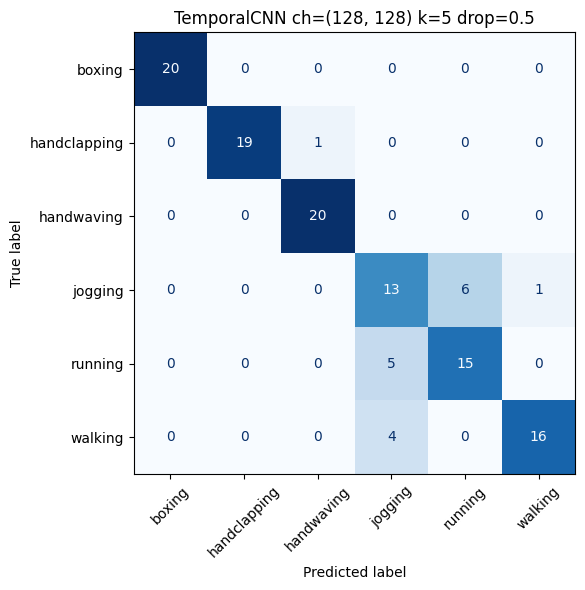

TemporalCNN Ablation: 100%|██████████| 7/7 [00:28<00:00,  4.09s/config]



TemporalCNN results saved to: outputs\results\results_temporal_cnn_ablation.csv


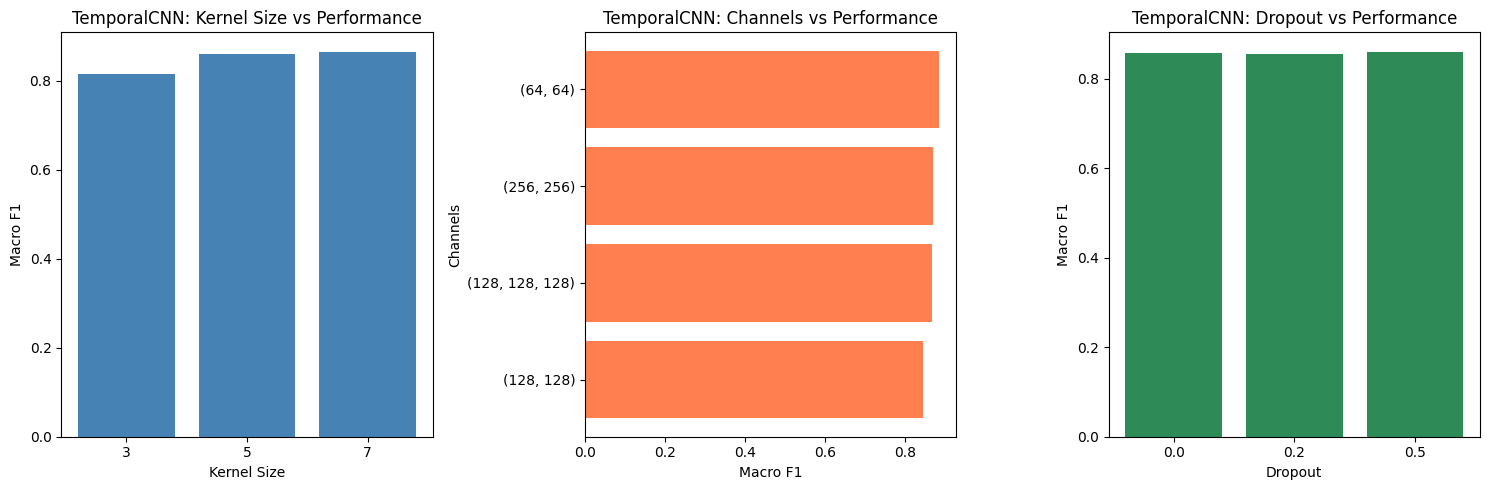


✓ TemporalCNN ablation complete!


In [19]:
# ==============================================================================
# CELL 15: TEMPORAL CNN ABLATION STUDY
# ==============================================================================
# Sweep Temporal CNN hyperparameters to find optimal configuration.
#
# Ablation dimensions:
# - kernel_size: Size of temporal convolution kernels
# - channels: Network architecture (width and depth)
# - dropout: Regularization strength
# ==============================================================================

def run_temporal_cnn_ablation(train_samples, test_samples):
    """
    Run comprehensive Temporal CNN ablation study.
    
    Tests various configurations and saves results for comparison.
    """
    # Define all configurations to test
    configs = [
        # Kernel size sweep
        {"channels": (128, 128), "kernel_size": 3, "dropout": 0.2},
        {"channels": (128, 128), "kernel_size": 5, "dropout": 0.2},  # baseline
        {"channels": (128, 128), "kernel_size": 7, "dropout": 0.2},
        
        # Channels sweep (width)
        {"channels": (64, 64), "kernel_size": 5, "dropout": 0.2},
        {"channels": (256, 256), "kernel_size": 5, "dropout": 0.2},
        
        # Channels sweep (depth)
        {"channels": (128, 128, 128), "kernel_size": 5, "dropout": 0.2},  # deeper
        
        # Dropout sweep
        {"channels": (128, 128), "kernel_size": 5, "dropout": 0.0},
        {"channels": (128, 128), "kernel_size": 5, "dropout": 0.5},
    ]
    
    # Skip already-run configs
    existing = {
        (r.get("method"), str(r.get("channels")), r.get("kernel_size"), r.get("dropout"))
        for r in RESULTS if r.get("method") == "TemporalCNN"
    }
    
    configs_to_run = [
        cfg for cfg in configs
        if ("TemporalCNN", str(cfg["channels"]), cfg["kernel_size"], cfg["dropout"]) not in existing
    ]
    
    print(f"Running {len(configs_to_run)} TemporalCNN configurations...")
    print(f"(Skipping {len(configs) - len(configs_to_run)} already completed)")
    
    for cfg in tqdm(configs_to_run, desc="TemporalCNN Ablation", unit="config"):
        try:
            model, hist, y_true, y_pred = train_temporal_cnn(
                train_samples, test_samples,
                channels=cfg["channels"],
                kernel_size=cfg["kernel_size"],
                dropout=cfg["dropout"],
                lr=1e-3,
                epochs=25,
                batch_size=32
            )
            
            title = f"TemporalCNN ch={cfg['channels']} k={cfg['kernel_size']} drop={cfg['dropout']}"
            ch_str = "_".join(map(str, cfg["channels"]))
            cm_path = FIG_DIR / f"cm_tcnn_ch{ch_str}_k{cfg['kernel_size']}_d{cfg['dropout']}.png"
            
            metrics = evaluate_and_report(y_true, y_pred, title=title, save_cm_path=cm_path)
            RESULTS.append({
                "method": "TemporalCNN",
                "channels": cfg["channels"],
                "kernel_size": cfg["kernel_size"],
                "dropout": cfg["dropout"],
                **metrics
            })
            
        except Exception as e:
            print(f"Error with config {cfg}: {e}")
    
    # Save results
    df_cnn = pd.DataFrame([r for r in RESULTS if r.get("method") == "TemporalCNN"])
    df_cnn.to_csv(RES_DIR / "results_temporal_cnn_ablation.csv", index=False)
    print(f"\nTemporalCNN results saved to: {RES_DIR / 'results_temporal_cnn_ablation.csv'}")
    
    # Plot ablation results
    if len(df_cnn) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Kernel size vs performance
        ax = axes[0]
        ks_perf = df_cnn.groupby("kernel_size")["macro_f1"].mean().reset_index()
        ax.bar(ks_perf["kernel_size"].astype(str), ks_perf["macro_f1"], color="steelblue")
        ax.set_xlabel("Kernel Size")
        ax.set_ylabel("Macro F1")
        ax.set_title("TemporalCNN: Kernel Size vs Performance")
        
        # Channels vs performance
        ax = axes[1]
        df_cnn["channels_str"] = df_cnn["channels"].apply(str)
        ch_perf = df_cnn.groupby("channels_str")["macro_f1"].mean().reset_index()
        ax.barh(ch_perf["channels_str"], ch_perf["macro_f1"], color="coral")
        ax.set_xlabel("Macro F1")
        ax.set_ylabel("Channels")
        ax.set_title("TemporalCNN: Channels vs Performance")
        
        # Dropout vs performance
        ax = axes[2]
        dr_perf = df_cnn.groupby("dropout")["macro_f1"].mean().reset_index()
        ax.bar(dr_perf["dropout"].astype(str), dr_perf["macro_f1"], color="seagreen")
        ax.set_xlabel("Dropout")
        ax.set_ylabel("Macro F1")
        ax.set_title("TemporalCNN: Dropout vs Performance")
        
        plt.tight_layout()
        plt.savefig(FIG_DIR / "temporal_cnn_ablation_summary.png", dpi=200)
        plt.show()
    
    print("\n✓ TemporalCNN ablation complete!")

# ---------------------- Run Ablation ----------------------
run_temporal_cnn_ablation(train_samples, test_samples)

# 7. Results aggregation & comparison (ALL methods)

**Owners:** Person A + Person B

### Completed Tasks:
- [X] Convert RESULTS list to DataFrame
- [X] Save comprehensive results to CSV
- [X] Create summary table (best configuration per method)
- [X] Create comparison visualizations:
  - [X] Overall accuracy/F1 bar charts
  - [X] Best configuration analysis
- [X] Identify winner and provide analysis

RESULTS AGGREGATION

Total experiments completed: 31


,method,sigma,C,title,accuracy,macro_f1,cm,n_shapelets,shapelet_lengths,hidden_dims,dropout,hidden_size,num_layers,bidirectional,channels,kernel_size
0,GAK+SVM,auto,1.0,GAK+SVM,0.733333,0.731539,"[[16, 4, 0, 0, 0, 0], [4, 11, 5, 0, 0, 0], [2,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GAK+SVM,0.5,0.1,GAK+SVM sigma=0.5 C=0.1,0.166667,0.047619,"[[0, 20, 0, 0, 0, 0], [0, 20, 0, 0, 0, 0], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GAK+SVM,0.5,1.0,GAK+SVM sigma=0.5 C=1.0,0.175000,0.063835,"[[0, 0, 0, 0, 0, 20], [0, 0, 0, 0, 0, 20], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GAK+SVM,0.5,10.0,GAK+SVM sigma=0.5 C=10.0,0.175000,0.063835,"[[0, 0, 0, 0, 0, 20], [0, 0, 0, 0, 0, 20], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GAK+SVM,1.0,0.1,GAK+SVM sigma=1.0 C=0.1,0.166667,0.047619,"[[0, 20, 0, 0, 0, 0], [0, 20, 0, 0, 0, 0], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GAK+SVM,1.0,1.0,GAK+SVM sigma=1.0 C=1.0,0.183333,0.080055,"[[0, 0, 0, 0, 0, 20], [0, 0, 0, 0, 0, 20], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GAK+SVM,1.0,10.0,GAK+SVM sigma=1.0 C=10.0,0.183333,0.080055,"[[0, 0, 0, 0, 0, 20], [0, 0, 0, 0, 0, 20], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GAK+SVM,2.0,0.1,GAK+SVM sigma=2.0 C=0.1,0.166667,0.047619,"[[0, 20, 0, 0, 0, 0], [0, 20, 0, 0, 0, 0], [0,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GAK+SVM,2.0,1.0,GAK+SVM sigma=2.0 C=1.0,0.591667,0.526394,"[[9, 0, 0, 0, 7, 4], [0, 0, 11, 0, 2, 7], [0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GAK+SVM,2.0,10.0,GAK+SVM sigma=2.0 C=10.0,0.591667,0.526394,"[[9, 0, 0, 0, 7, 4], [0, 0, 11, 0, 2, 7], [0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



All results saved to: outputs\results\results_all.csv

BEST CONFIGURATION PER METHOD

GAK+SVM:
  Accuracy: 0.7333
  Macro F1: 0.7315
  Config:   GAK+SVM

LSTM:
  Accuracy: 0.8000
  Macro F1: 0.7993
  Config:   LSTM h=256 L=2 bi=True drop=0.2

RandomShapelets+MLP:
  Accuracy: 0.8417
  Macro F1: 0.8442
  Config:   RandomShapelets+MLP

TemporalCNN:
  Accuracy: 0.8833
  Macro F1: 0.8838
  Config:   TemporalCNN ch=(64, 64) k=5 drop=0.2

METHOD COMPARISON VISUALIZATION


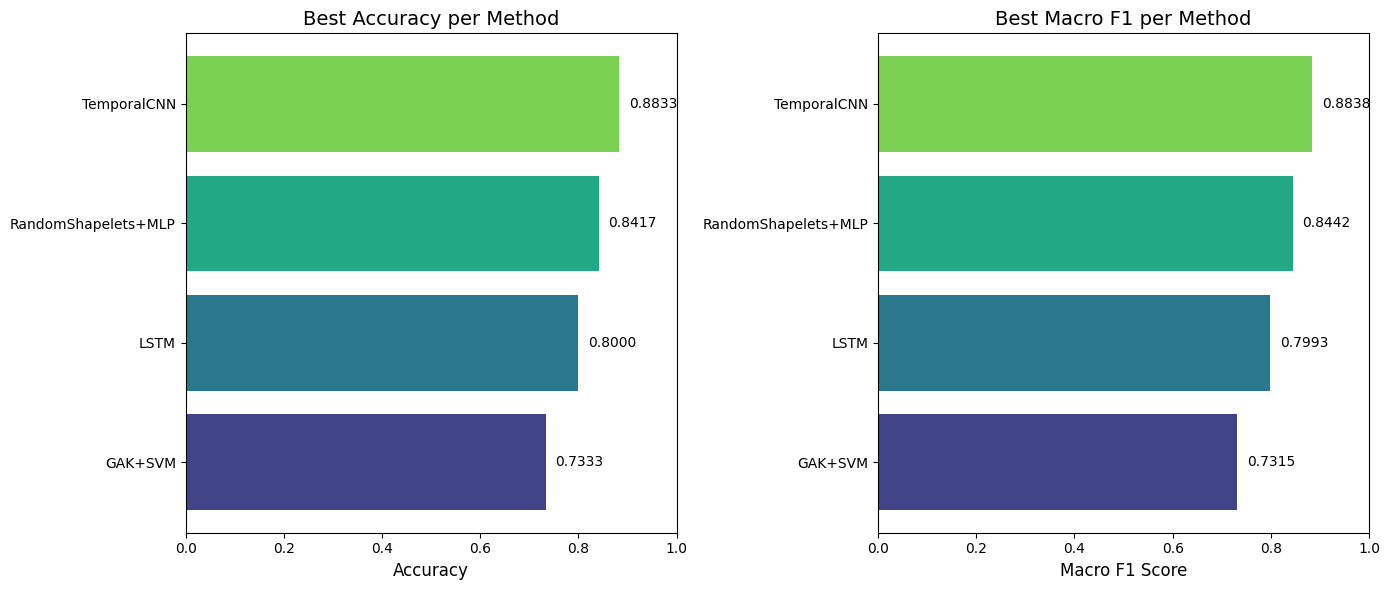


Best Configurations Summary Table:


,method,accuracy,macro_f1,title
26,TemporalCNN,0.883333,0.883773,"TemporalCNN ch=(64, 64) k=5 drop=0.2"
16,RandomShapelets+MLP,0.841667,0.844226,RandomShapelets+MLP
19,LSTM,0.800000,0.799263,LSTM h=256 L=2 bi=True drop=0.2
0,GAK+SVM,0.733333,0.731539,GAK+SVM



🏆 WINNER: TemporalCNN
   Accuracy:  0.8833
   Macro F1:  0.8838
   Config:    TemporalCNN ch=(64, 64) k=5 drop=0.2


In [20]:
# ==============================================================================
# CELL 16: RESULTS AGGREGATION AND COMPARISON
# ==============================================================================
# This cell aggregates all experiment results and creates comparison visualizations.
#
# Outputs:
# - CSV file with all results
# - Best configuration per method summary
# - Comparison bar charts (accuracy and macro F1)
# - Winner announcement with analysis
# ==============================================================================

def results_to_df(results_list):
    """
    Convert results list to DataFrame, handling special types.
    
    Converts numpy arrays (like confusion matrices) to string representation
    for CSV compatibility.
    
    Args:
        results_list: List of result dictionaries
        
    Returns:
        pandas DataFrame with all results
    """
    rows = []
    for r in results_list:
        rr = dict(r)
        # Convert confusion matrix to string for CSV storage
        if "cm" in rr and rr["cm"] is not None:
            rr["cm"] = str(rr["cm"].tolist())
        rows.append(rr)
    return pd.DataFrame(rows)

# ---------------------- Create Results DataFrame ----------------------
print("=" * 60)
print("RESULTS AGGREGATION")
print("=" * 60)

df_results = results_to_df(RESULTS)
print(f"\nTotal experiments completed: {len(df_results)}")

if len(df_results) > 0:
    display(df_results.head(10))
    
    # Save all results
    df_results.to_csv(RES_DIR / "results_all.csv", index=False)
    print(f"\nAll results saved to: {RES_DIR / 'results_all.csv'}")
    
    # ---------------------- Best Per Method Summary ----------------------
    print("\n" + "=" * 60)
    print("BEST CONFIGURATION PER METHOD")
    print("=" * 60)
    
    # Get best result (by macro_f1) for each method
    best = df_results.loc[df_results.groupby("method")["macro_f1"].idxmax()]
    
    for _, row in best.iterrows():
        print(f"\n{row['method']}:")
        print(f"  Accuracy: {row['accuracy']:.4f}")
        print(f"  Macro F1: {row['macro_f1']:.4f}")
        print(f"  Config:   {row['title']}")
    
    # ---------------------- Comparison Visualization ----------------------
    print("\n" + "=" * 60)
    print("METHOD COMPARISON VISUALIZATION")
    print("=" * 60)
    
    # Get best result per method
    best_per_method = df_results.loc[df_results.groupby("method")["macro_f1"].idxmax()].copy()
    best_per_method = best_per_method.sort_values("macro_f1", ascending=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Accuracy comparison (horizontal bar chart)
    ax = axes[0]
    methods = best_per_method["method"].values
    accuracies = best_per_method["accuracy"].values
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(methods)))
    
    bars = ax.barh(methods, accuracies, color=colors)
    ax.set_xlabel("Accuracy", fontsize=12)
    ax.set_title("Best Accuracy per Method", fontsize=14)
    ax.set_xlim(0, 1)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f"{acc:.4f}", va='center', fontsize=10)
    
    # Macro F1 comparison (horizontal bar chart)
    ax = axes[1]
    f1_scores = best_per_method["macro_f1"].values
    
    bars = ax.barh(methods, f1_scores, color=colors)
    ax.set_xlabel("Macro F1 Score", fontsize=12)
    ax.set_title("Best Macro F1 per Method", fontsize=14)
    ax.set_xlim(0, 1)
    
    # Add value labels
    for bar, f1 in zip(bars, f1_scores):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f"{f1:.4f}", va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / "method_comparison.png", dpi=200)
    plt.show()
    
    # ---------------------- Summary Table ----------------------
    print("\nBest Configurations Summary Table:")
    summary_df = best_per_method[["method", "accuracy", "macro_f1", "title"]].copy()
    summary_df = summary_df.sort_values("macro_f1", ascending=False)
    display(summary_df)
    
    # Save summary
    summary_df.to_csv(RES_DIR / "best_per_method.csv", index=False)
    
    # ---------------------- Winner Announcement ----------------------
    print("\n" + "=" * 60)
    winner = best_per_method.loc[best_per_method["macro_f1"].idxmax()]
    print(f"🏆 WINNER: {winner['method']}")
    print(f"   Accuracy:  {winner['accuracy']:.4f}")
    print(f"   Macro F1:  {winner['macro_f1']:.4f}")
    print(f"   Config:    {winner['title']}")
    print("=" * 60)

else:
    print("No results to aggregate yet. Run the method cells first.")

# 8. FINAL REPORT

**Owners:** Person A + Person B

---
# AIN313 Assignment 4
## Human Action Classification from Pose Time-Series

---

## 1. Problem Overview

We adressed the task of **human action classification** using **pose-based time-series data** instead of raw RGB video frames. Using time-series for a task like our's is a better approach: we avoid noise in data and keep motion for evaluation. Raw RGB videos contain background, lighting, clothes, etc; lots of irrelevant variation. Keeping only the necessary data lets us train the models faster and use less data for the learning process.  Each video sequence is converted into a multivariate time series using OpenPose BODY-25 keypoints, where each frame contains the (x, y, confidence) values of body joints.

The classification task involves **six action classes**:

- Boxing  
- Handclapping  
- Handwaving  
- Jogging  
- Running  
- Walking  

The goal is to evaluate and compare multiple time-series classification approaches under a consistent evaluation protocol. The evaluation protocol is mentioned and described in this report. 

---

## 2. Dataset and Representation
Raw data is represented by videos in .avi format, conveniently separated into folders by the action represented on the video. There are 6 actions: boxing, handwaving, jogging, running, walking. Low ~160x120 resolution, 35 fps, 25 actors per each action. For the GitHub hierarchy we added data/raw data/processed folders for consistency. 

### Preprocessing Summary
- Pose sequences are normalized and formatted into consistent tensor structures.
- Variable-length sequences are handled through padding or truncation depending on the model.
- We kept the confidence values hoping that using it as a feature will improve accuracy of the models.

From everything beforementioned, we can conclude that it is evidently a **multivariate time-series classification problem**.

---

## 3. Methods

### 3.1 GAK + SVM
Why using GAK?
Global Alignment Kernel measures similarity between two time series by aligning them in time. The result is a kernel matrix where each entry is similarity between two videos. In simple words, if two people move the same way (represented as a matrix), GAK evaluates them to be close, even if one is faster. SVM then separated actions based on these motion similarities.

Key hyperparameters:
- σ (sigma): kernel bandwidth controlling alignment smoothness
- C: SVM regularization parameter

An extensive ablation (parameter sweep) over (σ, C) is conducted to study sensitivity and stability.

---

### 3.2 Shapelet-Based Models

Shapelets are short, discriminative sub-sequences of the time series that we created. Instead of comparing whole series, shapelets identify small motion patterns that are a good characteristic of a class. Intuitively, a spesific arm swing might be a shapelet for handwaving. They work on local, informative patterns, not the entire sequence. 

Evaluated pipelines:
- RandomShapelets + MLP
- Statistical Feature Baseline + MLP

---

### 3.3 LSTM-Based Sequence Models

Long Short-Term Memory is a type of neural networks designed for sequences, It processes data step by step over time. Why is it useful in out project? Actions depend on how poses change over time, not diconnected single frames. We evaluated the following configurations: 
- A base LSTM model
- A deeper bidirectional LSTM with dropout

---

## 4. Evaluation Metrics

We report:
- Accuracy
- Macro-averaged F1-score


---

## 5. Results Summary

### GAK + SVM
We have observed interesting relusts in this model-pair: it is extremely sensitive to parameter tuning. If either of the parameters is too small/too large (sigma or C), it causes the model to give a single prediction for the entire dataset. We argued why it might happen:
Small sigma makes the kernel "too picky", and classifies nothing similar to anything. It makes the kernel to strive for perfection, meaning, if the time-steps are not almost identical, all the similarities vanish. It is obvious that movements of the human body can never be almost identical, but small sigma forces even minor pose differences to be treated as errors. 
On the coutrary, a sigma that is too large causes everything to be similar, the model is not picky enough, and all similarities turn out to be constant. Different actions, especially that are somewhat similar, all look equally similar. The kernel matrix becomes uniform and SVM sees no structure. 

**After receiving the results of the parameter sweep, we concluded that:**
Sigma too small: σ = 0.5 and σ = 1.0,
even with C = 1 or 10, performance stays very low (macro-F1 ≈ 0.064–0.080).
Sigma too big (in your sweep): σ = 10.0,
tends to degrade unless C is large (C=1 is weak; C=10 is much better).
As for C, it controls the trade-off between fitting the training data and keeping the decision boundary simple. Small C means mistakes are cheap, model prefers a simple boundary, allows large classification errors. Smaller C caused overlapping (somewhat similar) classes (walking / running / jogging) to merge. As a result, the model inclined to label them all as the same class. 
With big C (~10), misclassification becomes very expensive, which could improve the accuracy by separating subtle classes (e.g. walking vs running). In our case, we did not observe any significant harm done by choosing a larger C (see below). 

**For C, based on the sweep results, we concluded that:**
C too small: C = 0.1
,it collapses for every sigma (accuracy ≈ 0.1667, macro-F1 ≈ 0.0476).
C too big:  C = 10 is not universally “too big” (it’s tied-best at sigma=2), but it can hurt at some sigma (e.g., sigma=5 where C=1 > C=10).
The best paramether-pair for GAK + SVM:
| Sigma (σ) | C   | Macro-F1 |
|----------|-----|----------|
| 2.0      | 1.0 | 0.526    |
| 2.0      | 10.0| 0.526    |

### Shapelet-Based Methods
Shapelet-based representations combined with MLP classifiers achieved even a stronger performance. The sweep was over the mode capacity: number of shapelets, shapelet length(s) (how long each subsequence is) and MLP configurations (hidden size, fixed). 
We conducted a two-phase ablation study: sweep on shapelet configuration with fixed MLP, and sweep on MLP configurations with the best shapelets. 
In the end, he motions were "summarized well" by the shapelets, which lead to good accuracy resutls.
We received the confusion matrix: 
Upper-body actions (boxing, handclapping, handwaving) are classifies almost perfectly. Errors are concentrated in somewhat similar motions (jogging - running - walking

e.g. jogging -> running (7), running -> jogging (5)). Reason for the errors is that shapelets learn gestures well, but speed is not a gesture. 
In the ablation studies, we have captured that once the feauters are good, the classifier config is almost irrelevant.

### LSTM Models
LSTM models performed well but struggled with distinctions between similar actions such as jogging, running, and walking, same as the previous method. We argue that the reason of this is that LTSM learns how motions evolves with every frame, and not how fast it happens. It is crucial for such movements as walking, jogging and running. LTSM sees similar patterns stretched or compressed in time.
Important cue: Biderctional matters a lot, switching to false drops to ~0.64 acc / ~0.61 macro-F1. It is expected: A normal LSTM only knows what came before a frame, a bidirectional LTSM also knows what came after. Seeing both past and future helps the model judge the rhythm (of running vs jogging vs walking). 
Best config: hidden_size=256, num_layers=2, bidirectional=True, dropout=0.2
Accuracy = 0.800, Macro-F1 = 0.799.

### Temporal 1D CNN as an extra method
CNN performed reasonably, but not the best. Judging by the sweep, performance improves with moderate kernel size and depth, then saturates. However, CNNs struggle with long-range rhythm and speed, just like LSTM.

| Channels   | Kernel Size | Dropout | Accuracy | Macro-F1 |
|------------|-------------|---------|----------|----------|
| (64, 64)   | 5           | 0.2     | 0.8833   | 0.8838   |

---

## 6. Error Analysis

Across all models, the primary source of confusion occurs among:
- Jogging
- Running
- Walking

Upper-body dominant actions such as boxing, handclapping, and handwaving are classified with higher reliability due to more distinctive motion patterns.

---

## 7. Conclusion

We concluded that pose-based representations are effective for human action recognition. While we achieved a comparatively strong accuracy of >0.80 across several modesls, this is the ceilling for the used approach. For achieving better accuracy, it is crucial to add features that would aid in distinction of velocity-based movements.
Proposals for future work:
- Introducing velocity and acceleration features
- Improved handling of missing or low-confidence joints

## Dataset Overview & Pose Extraction

**Dataset:** KTH Actions dataset with 6 action classes (boxing, handclapping, handwaving, jogging, running, walking) performed by 25 actors in various scenarios.

**Pose Extraction:** OpenPose BODY-25 model extracts 25 keypoints per frame, each with (x, y, confidence). We use normalized (x, y) coordinates (confidence excluded) giving 50 features per frame.

**Preprocessing:**
- Normalize poses by centering (x, y) coordinates per frame using mean of valid joints
- Variable-length sequences (204-1492 frames) handled differently per method

---

## Methods Summary

### Method 1: GAK+SVM
- **Approach:** Global Alignment Kernel computes sequence similarity using soft-DTW alignment
- **Speed optimization:** Subsample sequences to 100 frames for tractable computation
- **Key hyperparameters:** sigma (kernel bandwidth), C (SVM regularization)

### Method 2: Shapelets+MLP
- **Approach:** Learn discriminative subsequences (shapelets) that characterize each class
- **Transform:** Convert sequences to distance-based fixed-length features
- **Classifier:** Multi-layer perceptron with dropout regularization

### Method 3: LSTM
- **Approach:** Bidirectional LSTM processes variable-length sequences
- **Key features:** Pack/pad sequences, use final hidden state for classification
- **Key hyperparameters:** hidden_size, num_layers, bidirectional, dropout

### Method 4: Temporal CNN
- **Approach:** 1D convolutions along time dimension capture local patterns
- **Architecture:** Conv1d -> ReLU -> Dropout -> MaxPool -> GlobalAvgPool -> FC
- **Key hyperparameters:** kernel_size, channels, dropout

---

## Ablation Design Summary

| Method | Hyperparameters Swept | Grid Size |
|--------|----------------------|-----------|
| GAK+SVM | sigma ∈ {0.5, 1.0, 2.0}, C ∈ {0.1, 1.0} | 6 configs |
| Shapelets+MLP | shapelet sizes/counts, MLP hidden dims | 6 configs |
| LSTM | hidden_size, num_layers, bidirectional, dropout | 8 configs |
| TemporalCNN | kernel_size, channels, dropout | 8 configs |

---

## Evaluation Protocol

- **Split:** GroupShuffleSplit by person ID (80/20 train/test)
- **Rationale:** Ensures no person appears in both train and test (prevents identity recognition)
- **Metrics:** Accuracy, Macro-F1, per-class precision/recall/F1, confusion matrix



## Acknowledgments

- **Dataset:** KTH Actions dataset
- **Pose Estimation:** OpenPose BODY-25 model
- **Libraries:** PyTorch, tslearn, scikit-learn, numpy, pandas, matplotlib

---
